In [12]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Spatial Manipulation
import geopandas as gpd
from shapely.geometry import Point

## Mapping
import folium
from folium import plugins

## Misc
import functools
from itertools import product
import contextily as ctx

pd.options.display.max_columns = None
pd.options.display.max_rows = None

from matplotlib.lines import Line2D 

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Schools and school run analysis 
### Data was processed in the base script


In [13]:
df = pd.read_csv('pm_no_clean.csv', index_col=0)

In [14]:
#function to make box plots

def make_box(title, order, x, x_labels, data):
    
    fig, axs = plt.subplots(dpi=120, nrows=2, figsize=(9, 8))

    order = order

    a = sns.boxplot(x=x,
                    y='no2_ugm3',
                    data=data,
                    showfliers=False,
                    palette='Set2',
                    order= order,
                    ax=axs[0])

    ax_1 = a.axes
    lines = ax_1.get_lines()
    categories = ax_1.get_xticks()

    for cat in categories:

        y = round(lines[4+cat*5].get_ydata()[0],1) 

        ax_1.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
    
    ax_1.axes.get_xaxis().set_ticks([])
    ax_1.axes.get_xaxis().set_visible(False)

    a.set_ylabel('Average No2 μg/m3') 
    a.set_title(title)
    
    #-----------------------
    
    b = sns.boxplot(x=x,
                     y='pm2_5_ugm3',
                     data=data,
                     showfliers=False,
                     palette='Set2',
                     order= order,
                     ax=axs[1])

    ax_1 = b.axes
    lines = ax_1.get_lines()
    categories = ax_1.get_xticks()

    for cat in categories:

        y = round(lines[4+cat*5].get_ydata()[0],1) 

        ax_1.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))

    b.set_xlabel('') 
    b.set_ylabel('Average PM 2.5 μg/m3')
    b.set(xticklabels= x_labels)
    
    plt.show()

In [15]:
# x axis options - morning school run,
#                  afternoon school run,
#                  school run,
#                  awake_asleep
# make_box(order, x, x_labels, y, pollutant)

### Average values marked on plot are MEDIAN values. Means are higher in all cases. Outliers have been masked. You can see outliers by changing 'showfliers' to True

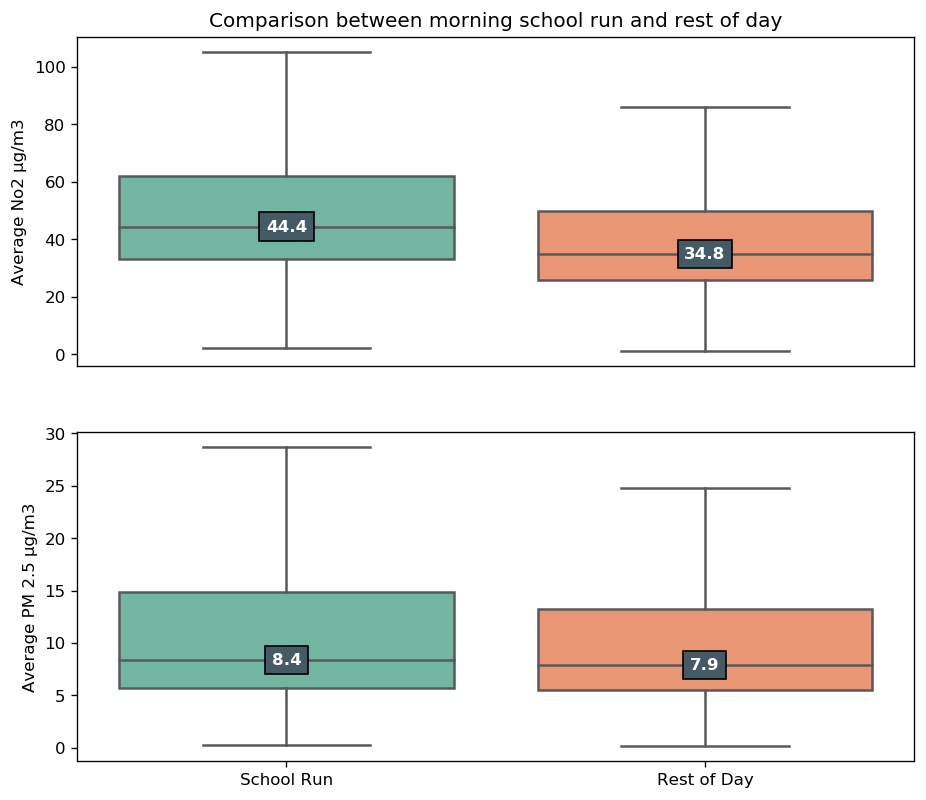

In [16]:
make_box('Comparison between morning school run and rest of day',
         ['school run', 'not morning school run'],
        'morning school run',
        ['School Run', 'Rest of Day'],
        df[df['day_type']=='weekday'])

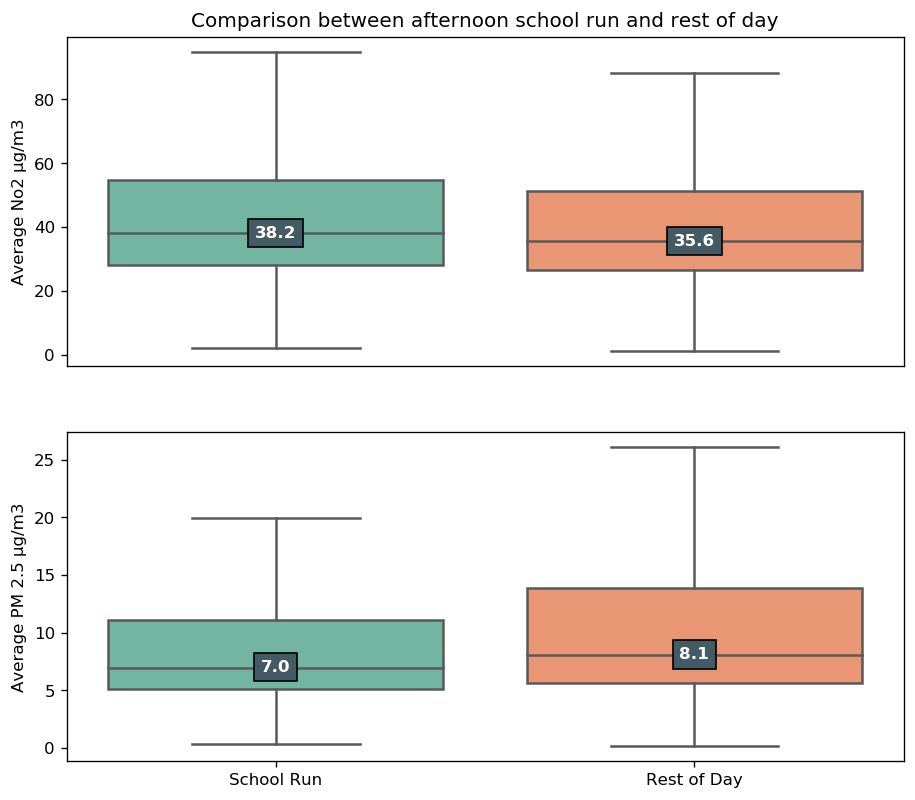

In [17]:
make_box('Comparison between afternoon school run and rest of day',
         ['school run', 'not afternoon school run'],
        'afternoon school run',
        ['School Run', 'Rest of Day'],
        df[df['day_type']=='weekday'])

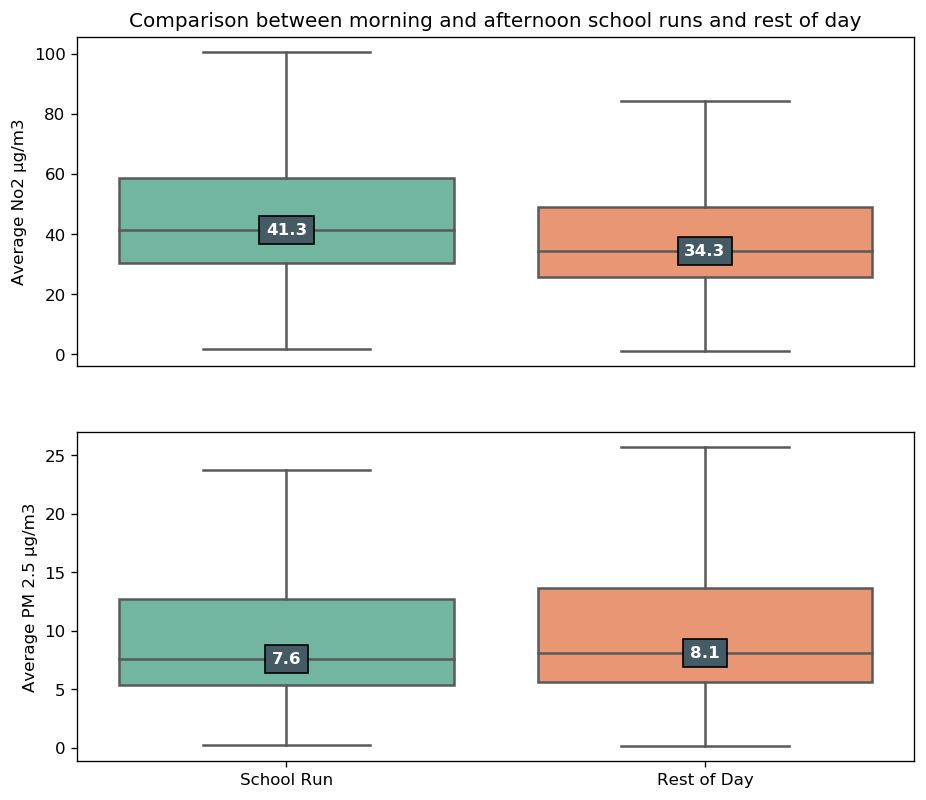

In [18]:
make_box('Comparison between morning and afternoon school runs and rest of day',
         ['school run', 'not school run'],
        'school run',
        ['School Run', 'Rest of Day'],
        df[df['day_type']=='weekday'])

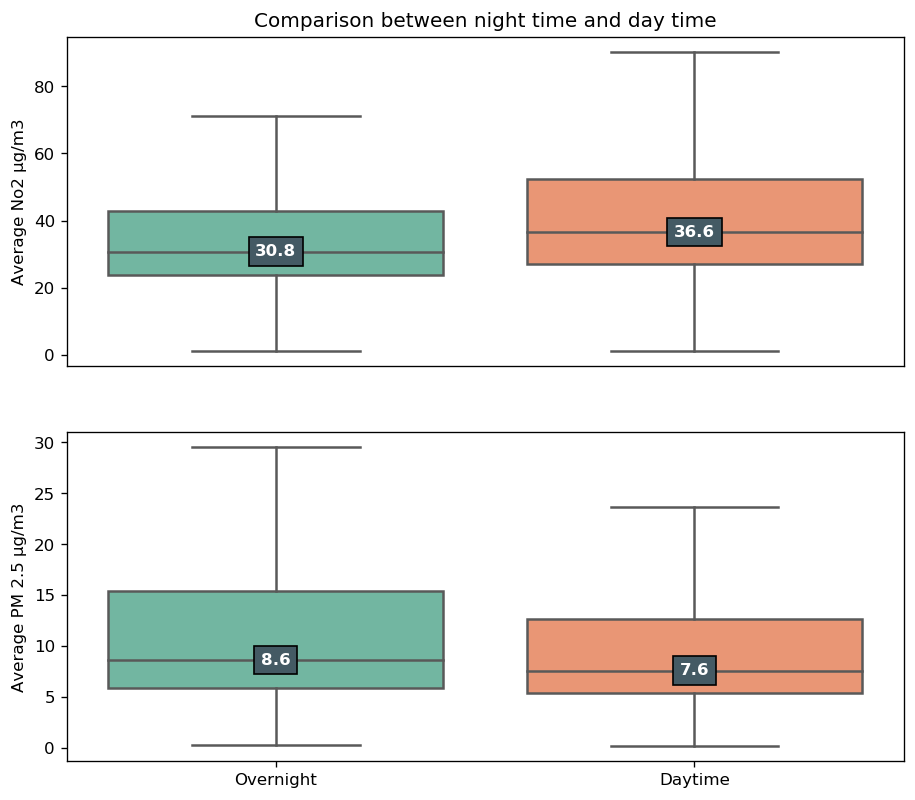

In [19]:
make_box('Comparison between night time and day time',
         ['sleeping', 'awake'],
        'awake_asleep',
        ['Overnight', 'Daytime'],
        df)

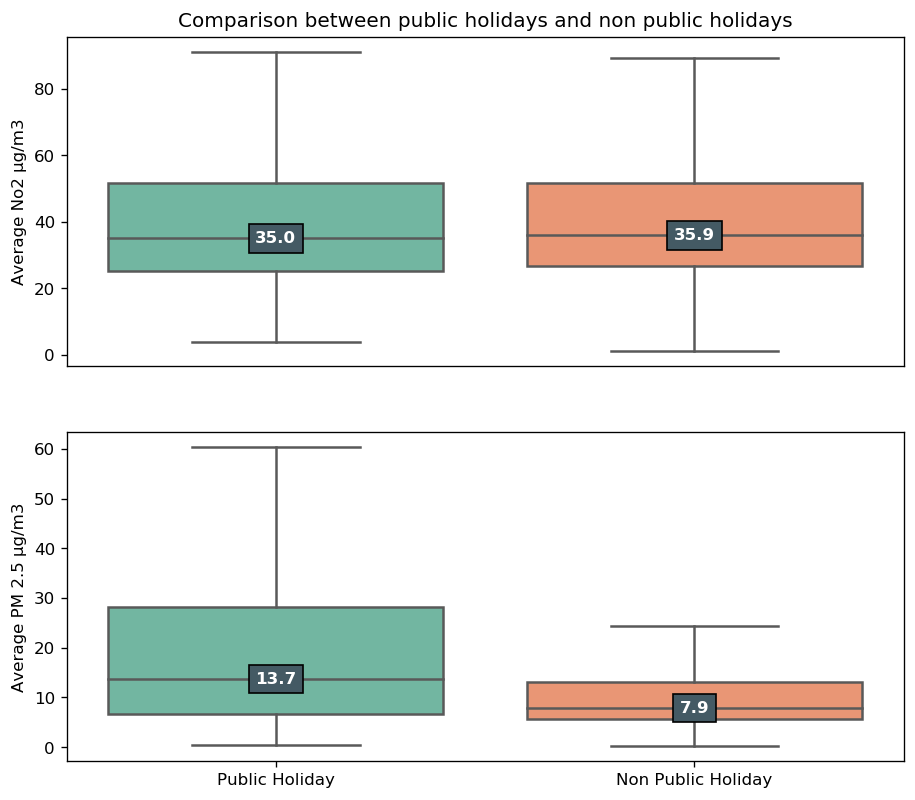

In [20]:
make_box('Comparison between public holidays and non public holidays',
         ['public holiday', 'non-holiday'],
        'public_hols',
        ['Public Holiday', 'Non Public Holiday'],
        df[df['day_type'] == 'weekday'])

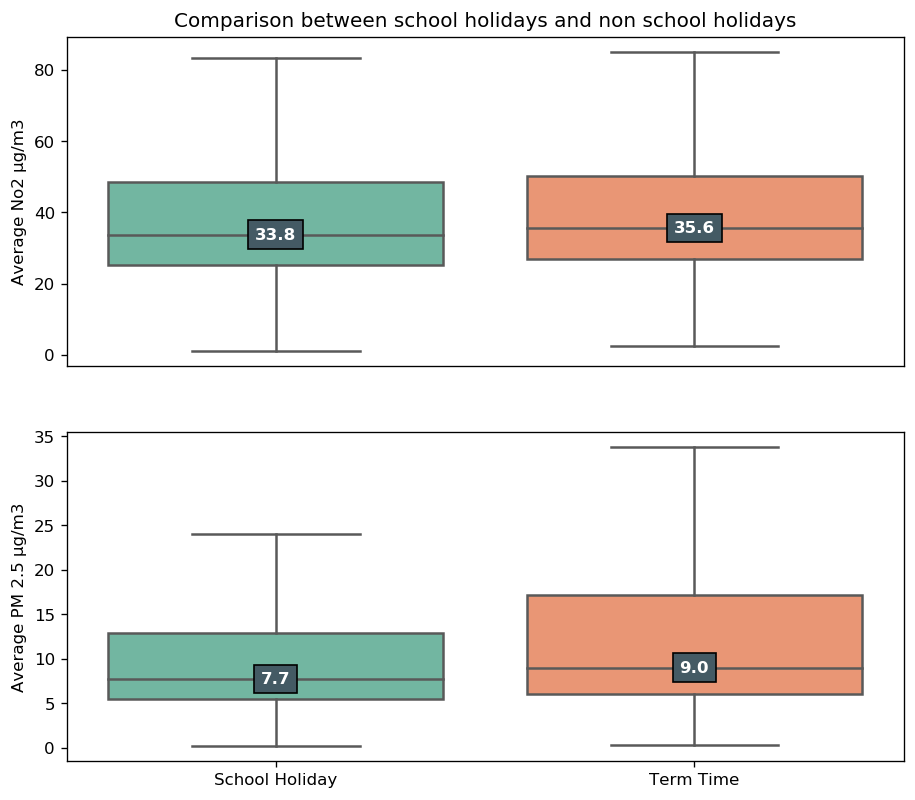

In [21]:
make_box('Comparison between school holidays and non school holidays',
         ['Term time', 'School Holiday'],
        'school_hol',
        ['School Holiday', 'Term Time'],
        df)

### It may be the case that the long summer holiday is influencing the lower average for school holiday PM2.5, since we know PM25 is lower in summer

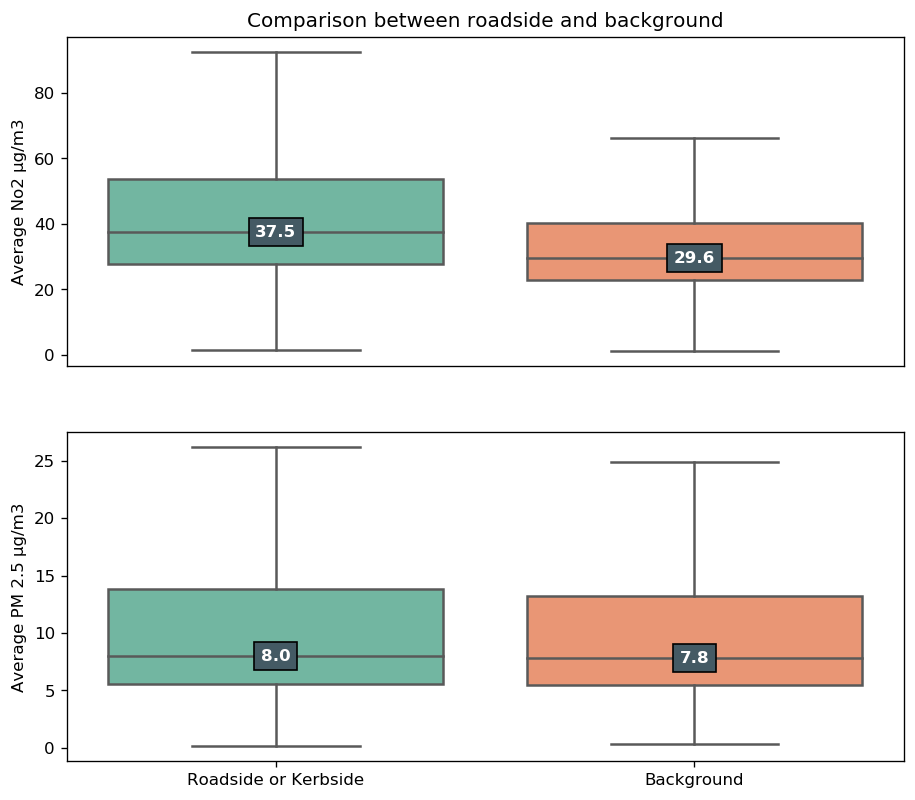

In [22]:
make_box('Comparison between roadside and background',
         ['roadside/kerbside', 'background'],
        'sensor_position',
        ['Roadside or Kerbside', 'Background'],
        df)

### 30% increase between roadside and background

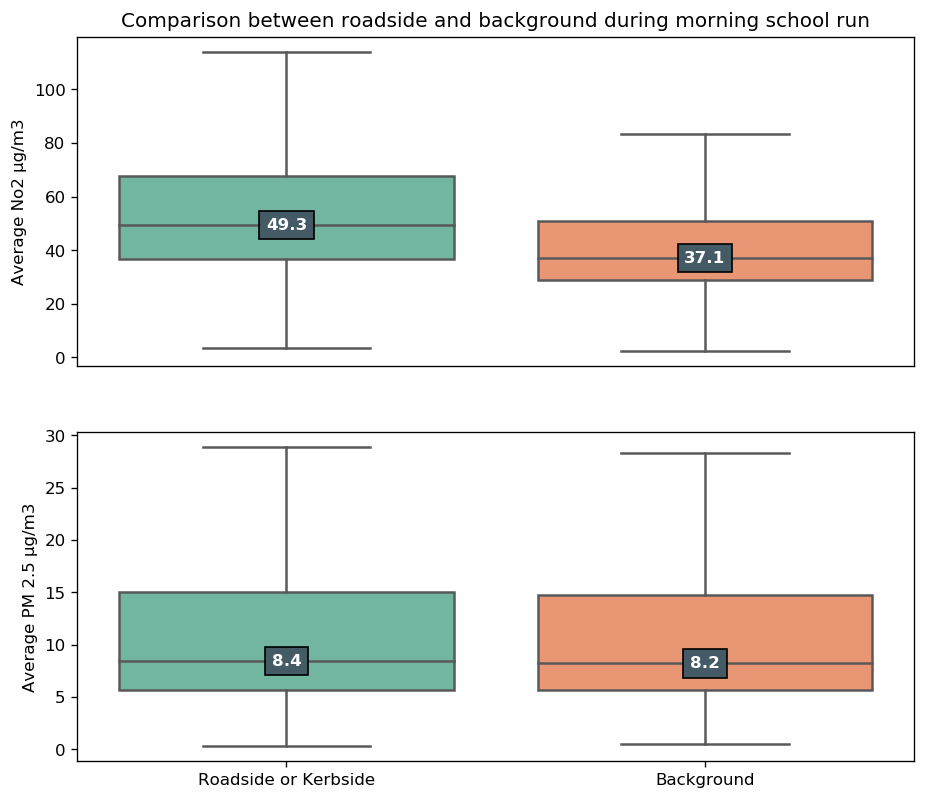

In [23]:
make_box('Comparison between roadside and background during morning school run',
         ['roadside/kerbside', 'background'],
        'sensor_position',
        ['Roadside or Kerbside', 'Background'],
        df[(df['morning school run'] == 'school run') & (df['day_type'] == 'weekday')])

### Looking at school statistics for 2019. Assuming a school day is between 0900 and 1600. Only considering schools in background locations

In [24]:
df['date_UTC'] = pd.to_datetime(df["date_UTC"])
df = df[df['date_UTC'].dt.year == 2019]

df = df.set_index('date_UTC')

In [25]:
df_school = df.between_time('09:00','16:00').copy()

In [26]:
df_school = df_school[(df_school['school_hol'] == 'Term time') 
                      & (df_school['day_type'] == 'weekday') 
                      & (df_school['Site_Type_x'] == 'School')
                      & (df_school['Type'] == 'Urban Background')]

In [27]:
#adding column for average during school hours no2
df_school['avg_no2_school'] = df_school.groupby('pod_id_location', as_index=False)['no2_ugm3'].transform('mean') 

#adding column for average during school hours pm25
df_school['avg_pm25_school'] = df_school.groupby('pod_id_location', as_index=False)['pm2_5_ugm3'].transform('mean') 

In [28]:
def make_diurnal(type, pollutant, title):

    plt.rcParams['figure.dpi'] = 90

    col_order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

    g = sns.relplot(x='hour', y=pollutant,
                     col="w_day", hue="Zone",
                     kind=type, ci=95, data=df_school, col_order=col_order)

    axes = g.axes.flatten()
    axes[0].set_title("Monday")
    axes[1].set_title("Tuesday")
    axes[2].set_title("Wednesday")
    axes[3].set_title("Thursday")
    axes[4].set_title("Friday")

    axes[0].set_ylabel("Hourly No2")
    for ax in axes:
        ax.set_xlabel("Hour")

    g.fig.suptitle('Diurnal '+ type +' plot to show hourly '+ type +' for schools during term time and school hours', 
                   weight='semibold', 
                   y= 1.06, 
                   size='x-large')

    #plt.margins(x=0)
    #plt.subplots_adjust(hspace==, wspace=0)
    plt.show()

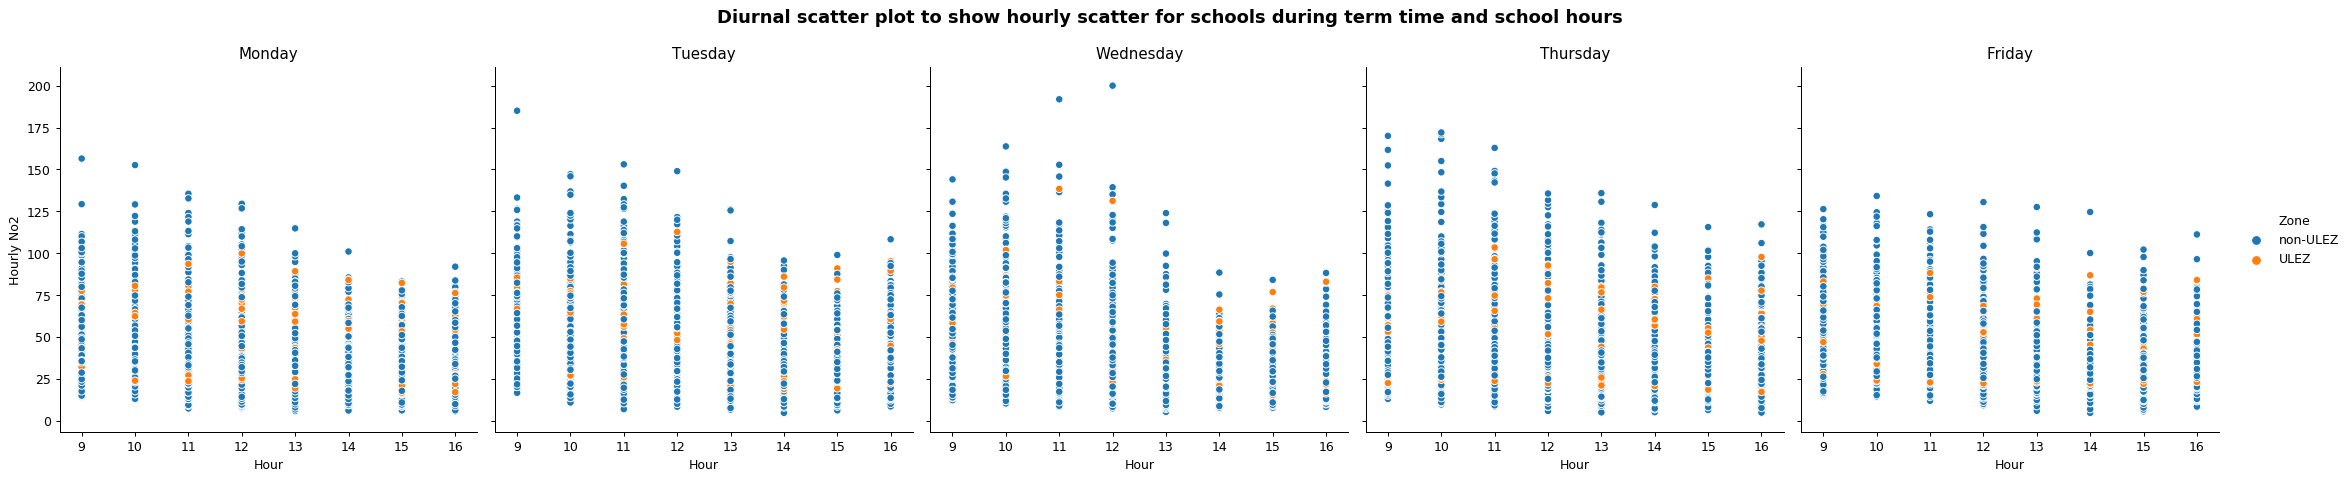

In [29]:
#line or scatter - no2

make_diurnal('scatter', 'no2_ugm3', 'No2')

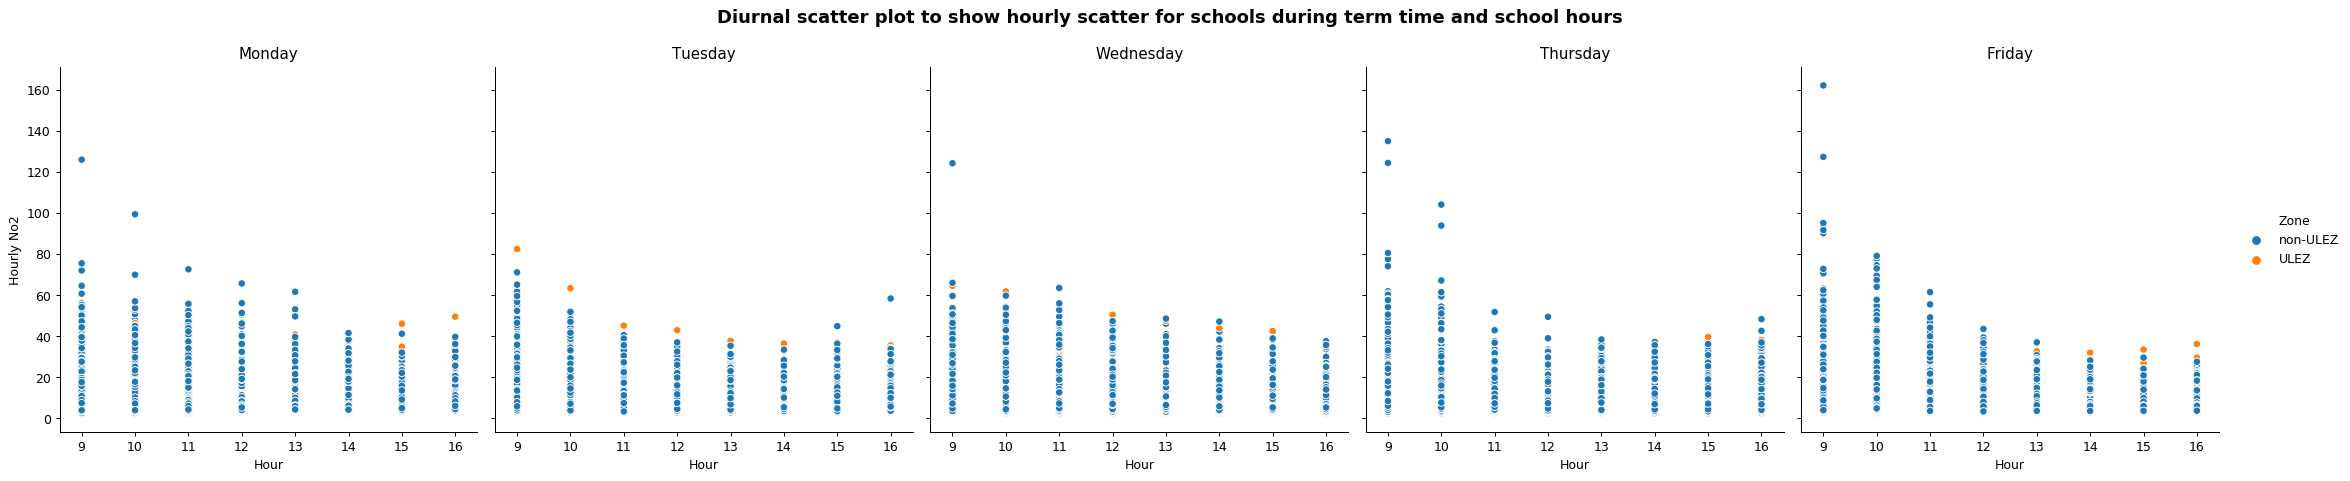

In [30]:
#line or scatter - no2

make_diurnal('scatter', 'pm2_5_ugm3', 'PM 2.5')

In [31]:
df_school_pm25 = df_school.copy()
df_school_pm25['hourly_mean_sensor'] = df_school_pm25.groupby(['pod_id_location', df_school_pm25['hour']])['pm2_5_ugm3'].transform('mean') 

In [32]:
df_school_pm25 = df_school_pm25.drop_duplicates(['hour','pod_id_location'],keep= 'first')

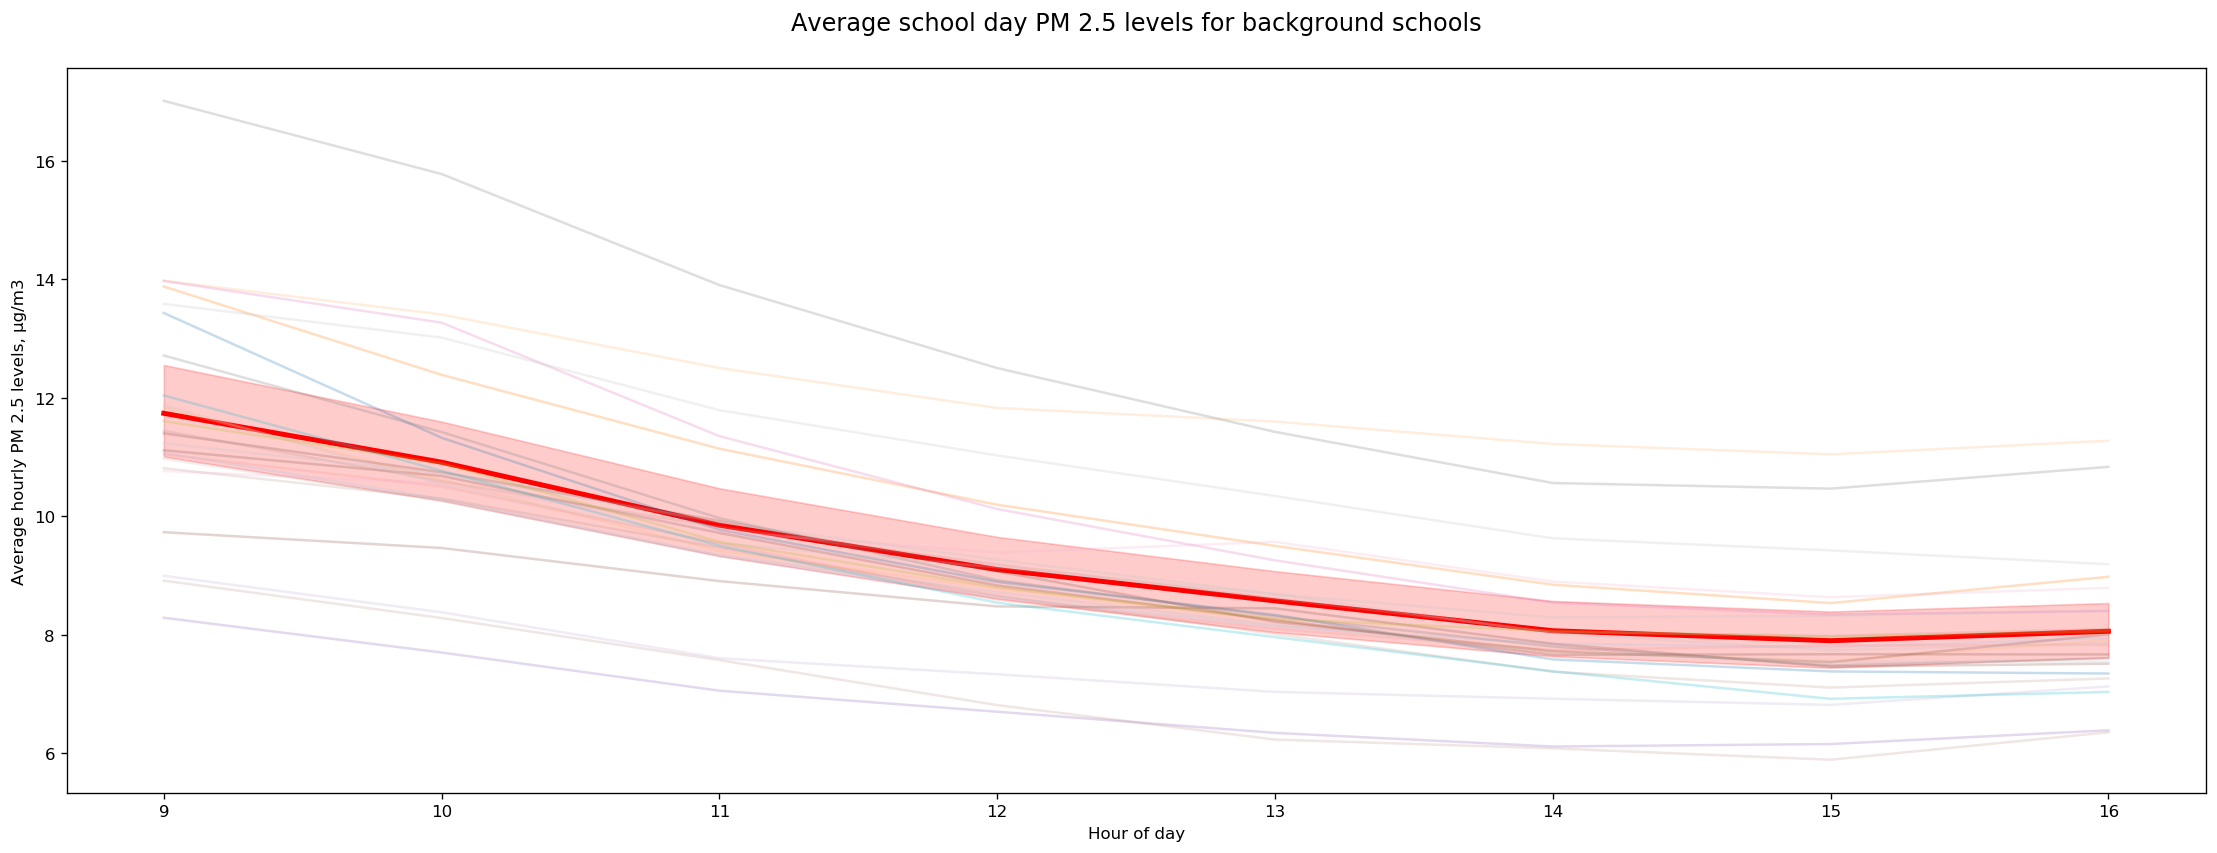

In [33]:
plt.rcParams['figure.figsize'] = [23, 8]
plt.rcParams['figure.dpi'] = 120

p = sns.lineplot(x='hour', y = 'hourly_mean_sensor', 
                 data = df_school_pm25,
                 linewidth=3,
                 color = 'r',
                ci=95)


#p.set(ylim=(10,100))
p.set_title("Average school day PM 2.5 levels for background schools\n", size = 'x-large')

q = sns.lineplot(x='hour', y = 'hourly_mean_sensor', 
                 data = df_school_pm25,
                 hue = 'pod_id_location',
                 alpha = 0.25,
                 palette = 'tab20',
                 legend = False)
q.set(xlabel='Hour of day', ylabel='Average hourly PM 2.5 levels, µg/m3')

plt.xticks(np.arange(min(df_school_pm25['hour']), max(df_school_pm25['hour'])+1, 1.0))
plt.show()

### We see PM 2.5 is worst during the morning, when children are walking to school. Should children be doing PE in the morning, or in the afternoon when PM 2.5 levels are lower. We see individual schools (fainter lines) have significantly different hourly averages.

In [34]:
df_school_no2 = df_school.copy()
df_school_no2['hourly_mean_sensor'] = df_school_no2.groupby(['pod_id_location', df_school_no2['hour']])['no2_ugm3'].transform('mean')

In [35]:
df_school_no2 = df_school_no2.drop_duplicates(['hour','pod_id_location'],keep= 'first')

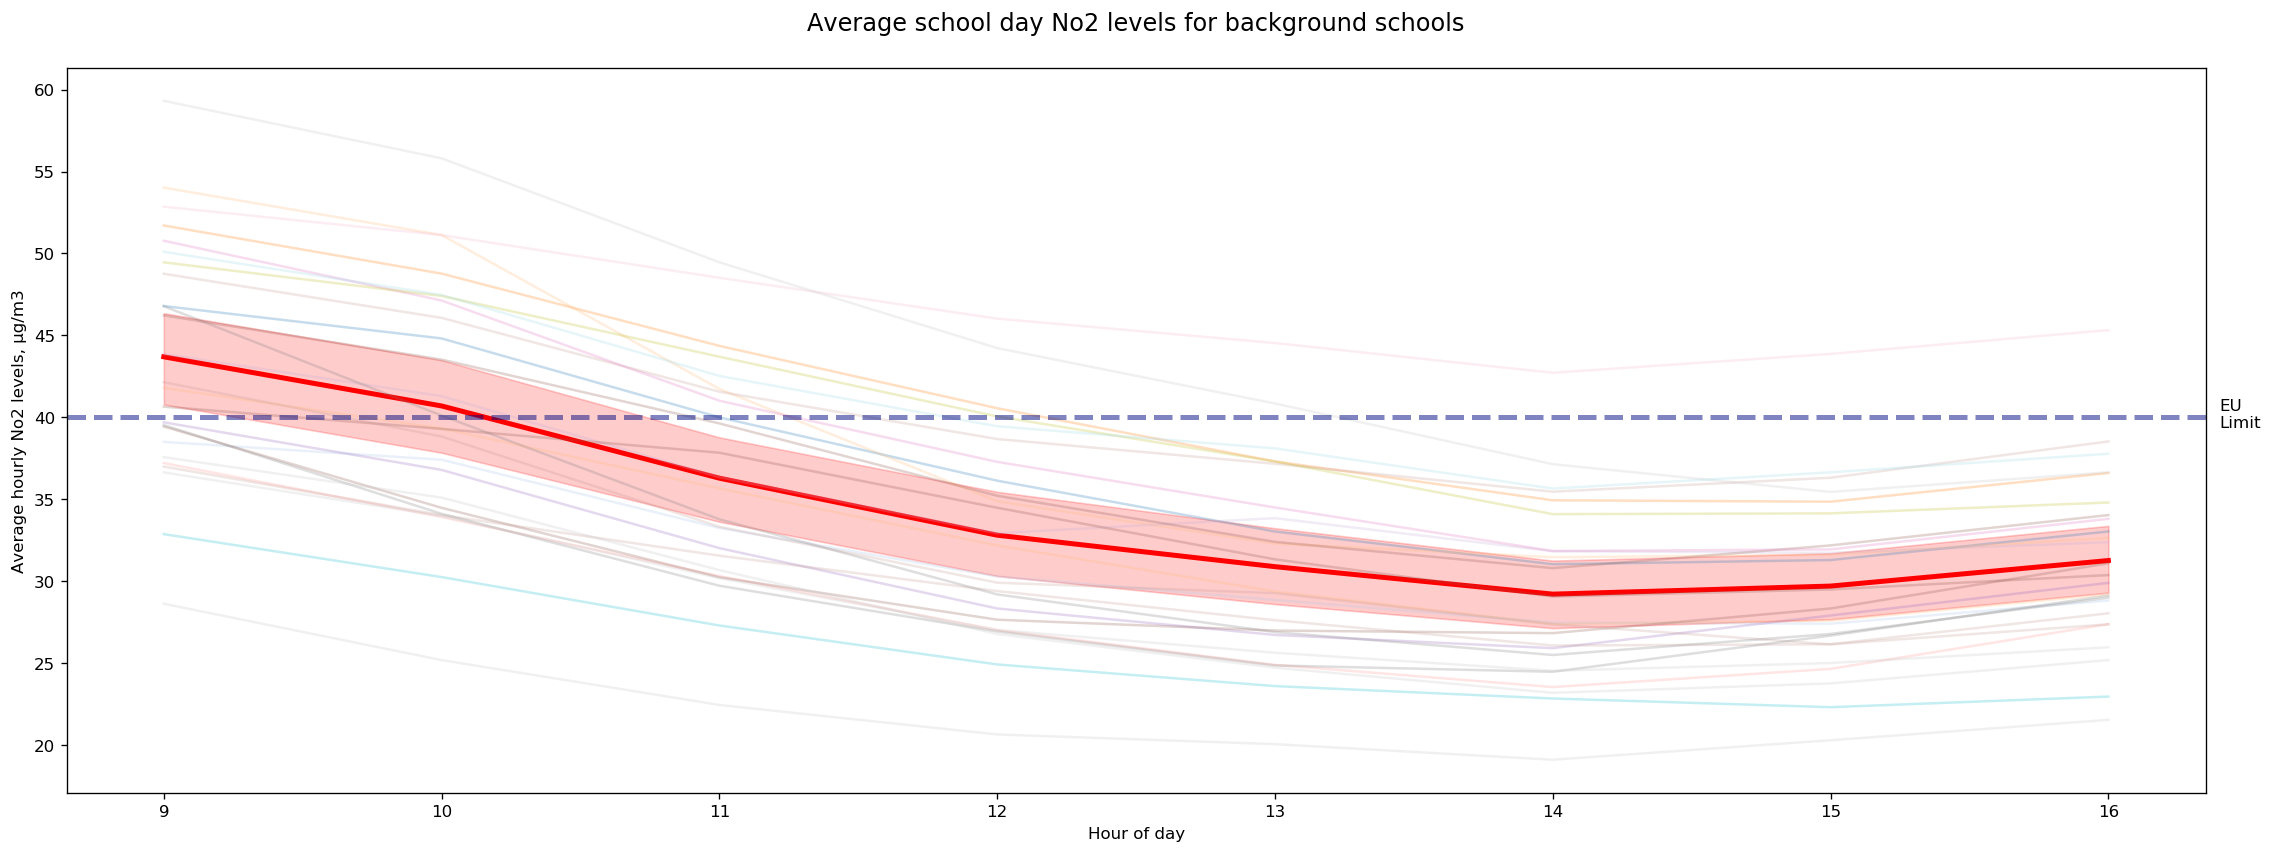

In [36]:
plt.rcParams['figure.figsize'] = [23, 8]
plt.rcParams['figure.dpi'] = 120

p = sns.lineplot(x='hour', y = 'hourly_mean_sensor', 
                 data = df_school_no2,
                 linewidth=3,
                 color = 'r',
                ci=95)


#p.set(ylim=(10,100))
p.set_title("Average school day No2 levels for background schools\n", size = 'x-large')

q = sns.lineplot(x='hour', y = 'hourly_mean_sensor', 
                 data = df_school_no2,
                 hue = 'pod_id_location',
                 alpha = 0.25,
                 palette = 'tab20',
                 legend = False)
q.set(xlabel='Hour of day', ylabel='Average hourly No2 levels, µg/m3')

q.axhline(40, ls='--', linewidth=3, color='#000980', alpha = 0.5)
q.text(16.4,39.4, "EU\nLimit")

plt.xticks(np.arange(min(df_school_no2['hour']), max(df_school_no2['hour'])+1, 1.0))
plt.show()

### Again No2 levels significantly higher in the morning, in many cases passing the 40 µg/m3 limit

## Plotting these schools on a map

In [37]:
#turning df into GIS file
geometry = [Point(xy) for xy in zip(df_school_no2.Longitude, df_school_no2.Latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df_school_no2, crs = crs, geometry=geometry)
gdf = gdf.to_crs({'init': 'epsg:3857'})

In [38]:
gdf = gdf.dropna(subset=['avg_no2_school'])
gdf = gdf.drop_duplicates(subset=['pod_id_location'])

In [39]:
#loading ULEZ
path = "/Users/oliverpaul/Data_Science/EDF/LAEI - GIS geographies/Ultra_Low_Emissions_Zone.gpkg"
ULEZ = gpd.read_file(path)
crs = {'init': 'epsg:27700'}
ULEZ = gpd.GeoDataFrame(ULEZ, crs=crs)
ULEZ = ULEZ.to_crs({'init': 'epsg:3857'})

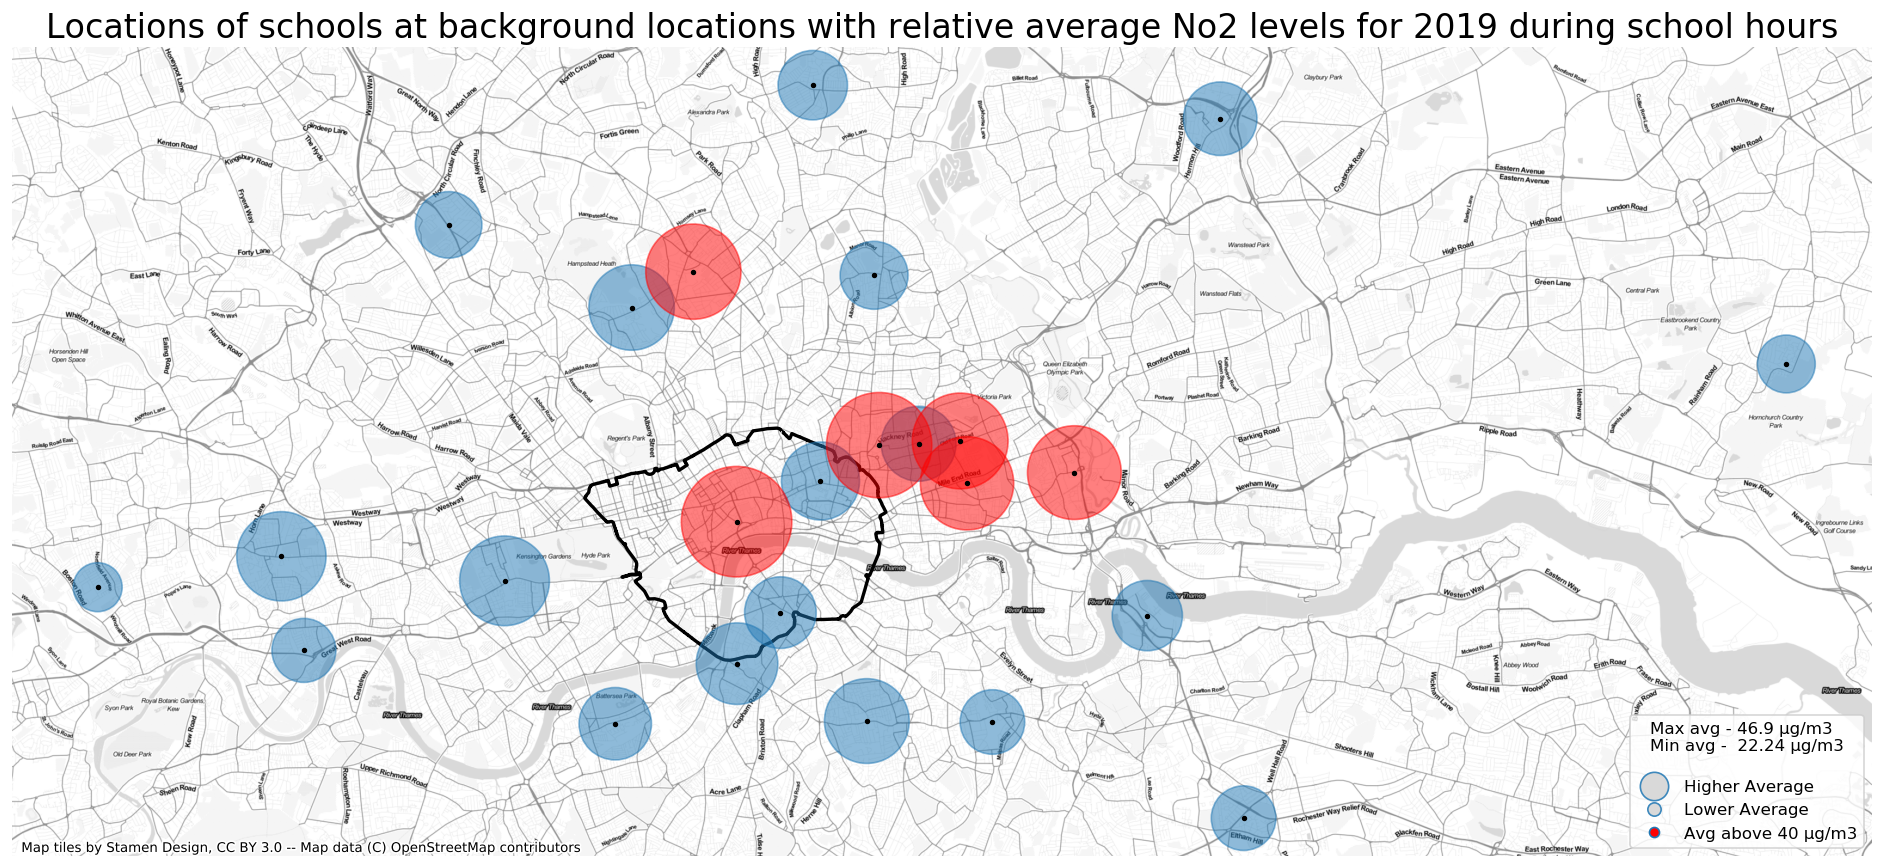

In [40]:
plt.rcParams['figure.dpi'] = 120

ax = gdf[gdf['avg_no2_school'] < 40].plot(figsize=(20, 20), markersize = (gdf[gdf['avg_no2_school'] < 40]['avg_no2_school'])**2.18, zorder = 50, alpha=0.5)
g = gdf[gdf['avg_no2_school'] >= 40].plot(figsize=(20, 20), markersize = (gdf[gdf['avg_no2_school'] >= 40]['avg_no2_school'])**2.18, zorder = 50, alpha=0.5, facecolor='red', ax=ax)


gdf.plot(ax=ax, markersize = 5, zorder = 50, facecolor='black')

ULEZ.plot(figsize=(20, 20), edgecolor='k', facecolor='none', linewidth=2, zorder = 1, ax=ax)

ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

circ1 = Line2D([0], [0], linestyle="none", marker="o", markersize=17, markerfacecolor="lightgray", alpha = 0.85)
circ2 = Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor="lightgray", alpha = 0.85)
circ3 = Line2D([0], [0], linestyle="none", marker="o", markersize=6, markerfacecolor="red", alpha = 1)

leg = ax.legend((circ1, circ2, circ3), ("Higher Average", "Lower Average", "Avg above 40 µg/m3"), 
                      numpoints=1, 
                      loc=4).set_title('Max avg - 46.9 µg/m3\nMin avg -  22.24 µg/m3\n')

ax.set_title('Locations of schools at background locations with relative average No2 levels for 2019 during school hours', 
                 fontdict={'fontsize': '20', 'fontweight' : '2'})

plt.axis('off')
plt.show()

In [41]:
#turning df into GIS file for pm2.5
geometry = [Point(xy) for xy in zip(df_school_pm25.Longitude, df_school_pm25.Latitude)]
crs = {'init': 'epsg:4326'}
gdf_pm = gpd.GeoDataFrame(df_school_pm25, crs = crs, geometry=geometry)
gdf_pm = gdf_pm.to_crs({'init': 'epsg:3857'})

In [42]:
gdf_pm = gdf_pm.dropna(subset=['avg_pm25_school'])
gdf_pm = gdf_pm.drop_duplicates(subset=['pod_id_location'])

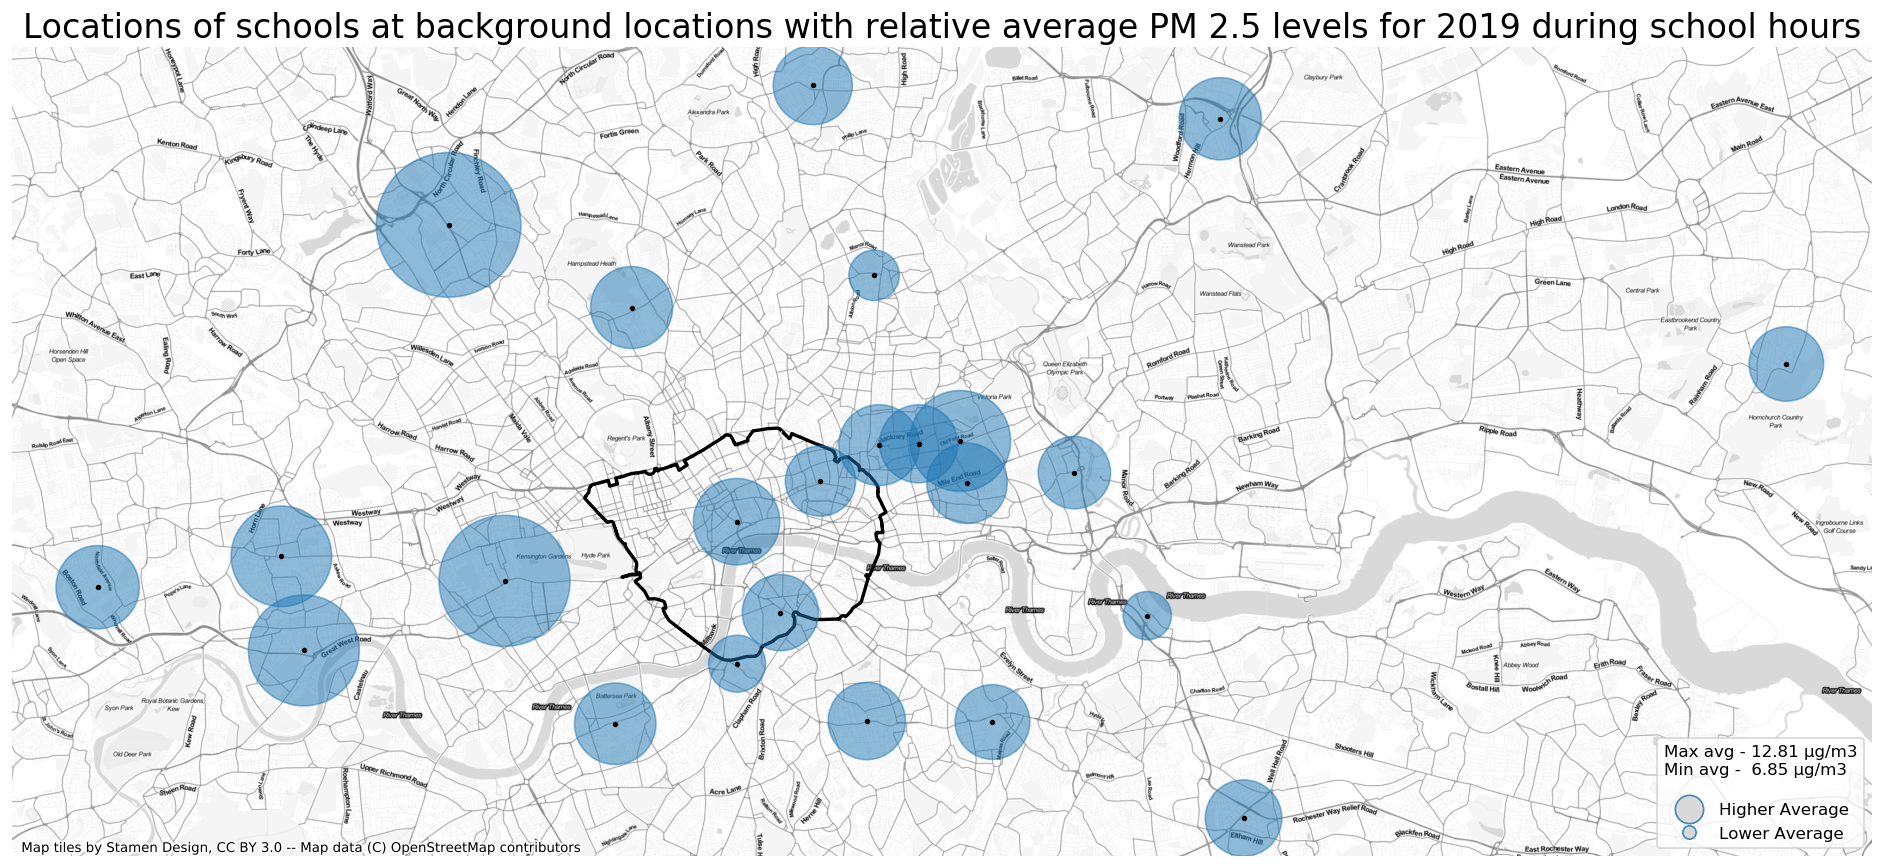

In [43]:
plt.rcParams['figure.dpi'] = 120

ax = gdf_pm.plot(figsize=(20, 20), markersize = gdf_pm['avg_pm25_school']**3.5, zorder = 50, alpha=0.5)

gdf_pm.plot(ax=ax, markersize = 5, zorder = 50, facecolor='black')

ULEZ.plot(figsize=(20, 20), edgecolor='k', facecolor='none', linewidth=2, zorder = 1, ax=ax)

ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

circ1 = Line2D([0], [0], linestyle="none", marker="o", markersize=17, markerfacecolor="lightgray", alpha = 0.85)
circ2 = Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor="lightgray", alpha = 0.85)

leg = ax.legend((circ1, circ2), ("Higher Average", "Lower Average"), 
                      numpoints=1, 
                      loc=4).set_title('Max avg - 12.81 µg/m3\nMin avg -  6.85 µg/m3\n')

ax.set_title('Locations of schools at background locations with relative average PM 2.5 levels for 2019 during school hours', 
                 fontdict={'fontsize': '20', 'fontweight' : '2'})

plt.axis('off')
plt.show()

### Whilst high NO2 levels seems to be centered around area north of the river with high levels of congestion, the highest PM 2.5 levels seem to be to the east of the ULEZ. 

## LSOA analysis - Please note, the sample size is small. Look at the maps to see how many schools there are in each LSOA decile category for a sense check

In [44]:
#filtering df for schools, background, weekday, term time 

df_lsoa = df[(df['school_hol'] == 'Term time') 
             & (df['day_type'] == 'weekday') 
             & (df['Site_Type_x'] == 'School')
             & (df['Type'] == 'Urban Background')].copy()

In [45]:
#Function for LSOA boxplots

def box_lsoa(title, variable, order, data):
    
    fig, axs = plt.subplots(dpi=120, nrows=2, figsize=(9, 7))

    a = sns.boxplot(x=variable, 
                    y='pm2_5_ugm3', 
                    data = data, 
                    showfliers = False,
                    palette='Set2',
                    order=order,
                    ax=axs[0])

    ax_0 = a.axes
    lines = ax_0.get_lines()
    categories = ax_0.get_xticks()

    ax_0.axes.get_xaxis().set_ticks([])
    ax_0.axes.get_xaxis().set_visible(False)

    for cat in categories:

        y = round(lines[4+cat*5].get_ydata()[0],1) 

        ax_0.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))

    a.figure.tight_layout()

    ax_0.grid(False)
    fig.suptitle(title, 
                 weight='semibold', 
                 y= 1.07, 
                 size='x-large')

    a.set(ylabel='Average PM 2.5 concentrations in µg/m3')

    ##----------------------------------

    b = sns.boxplot(x=variable, 
                    y='no2_ugm3', 
                    data = data, 
                    showfliers = False,
                    palette='Set2',
                    order=order,
                    ax=axs[1])

    ax_1 = b.axes
    lines = ax_1.get_lines()
    categories = ax_1.get_xticks()

    for cat in categories:

        y = round(lines[4+cat*5].get_ydata()[0],1) 

        ax_1.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))

    b.figure.tight_layout()
    b.set(ylabel='Average No2 concentrations in µg/m3')

    ax_1.grid(False)

In [46]:
#converting lsoa demographic data to strings so we can plot at categories 

df_lsoa['Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Income Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Income Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Employment Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Employment Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Crime Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Crime Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)
df_lsoa['Living Environment Decile (where 1 is most deprived 10% of LSOAs)'] = df_lsoa['Living Environment Decile (where 1 is most deprived 10% of LSOAs)'].astype(str)

In [54]:
def make_lsoa_map(variable, title):
    
    plt.rcParams['figure.dpi'] = 120

    ax=gdf.plot(figsize=(10, 10), 
                column=variable, 
                cmap='Set2', 
                legend=True, 
                alpha=1, 
                categorical=True)
    ULEZ.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2, alpha=0.5)
    ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

    ax.set_title(title, fontdict={'fontsize': 'x-large', 'fontweight' : 'semibold'})
    plt.axis('off')

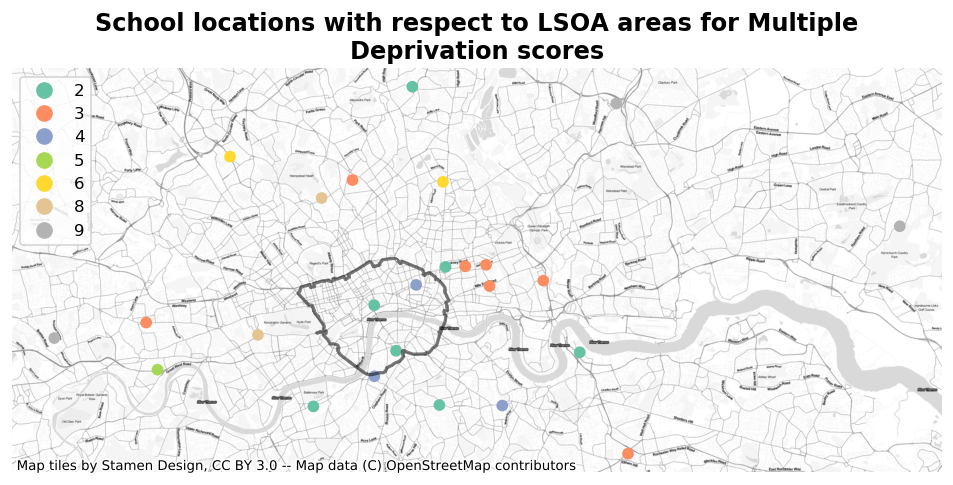

In [55]:
make_lsoa_map('Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
             'School locations with respect to LSOA areas for Multiple\nDeprivation scores')

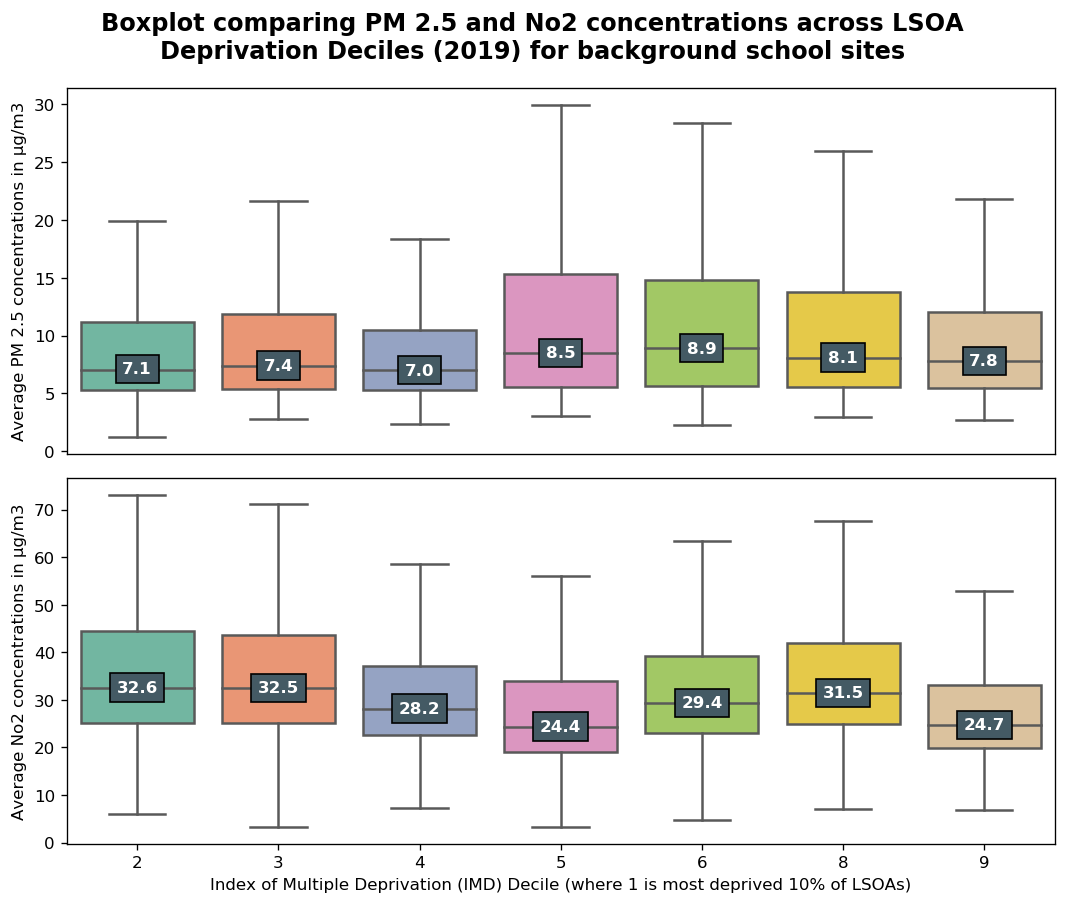

In [56]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across LSOA\nDeprivation Deciles (2019) for background school sites', 
         'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
        None, df_lsoa)

### Making the same plot, but during the morning school run

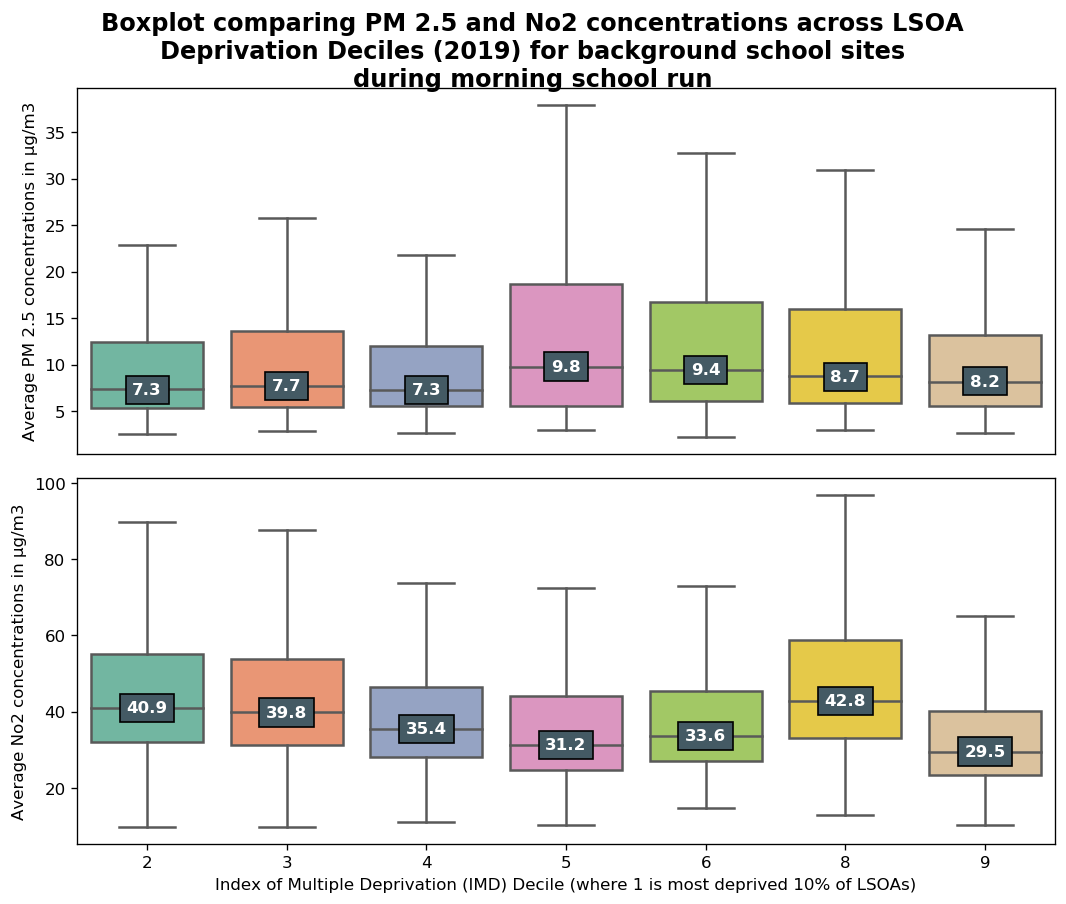

In [57]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across LSOA\nDeprivation Deciles (2019) for background school sites\nduring morning school run', 
         'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
        None, df_lsoa[df_lsoa['morning school run'] == 'school run'])

### Whilst there doesnt seem to be a trend between deprivation deciles, note that there is a 27% difference between No2 exposure between the second most deprived decile and the second least deprived decile (2nd and 9th) rising to 32% during the morning school run/rush hour. Since we have a very small sample for each LOSA category, this analysis should be extended to increase sample size.

In [58]:
df_imd = pd.DataFrame({
'Decile': [2,3,4,5,6,8,9],
'Day Median': [32.6, 32.5, 28.2, 24.4, 29.4, 31.5, 24.7],
'School Run Median': [40.9, 39.8, 35.4, 31.2, 33.6, 42.8, 29.5]})

In [59]:
x = df_imd['Day Median']
y = df_imd['School Run Median']

df_imd['percentage increase'] = ((y-x)/x)*100

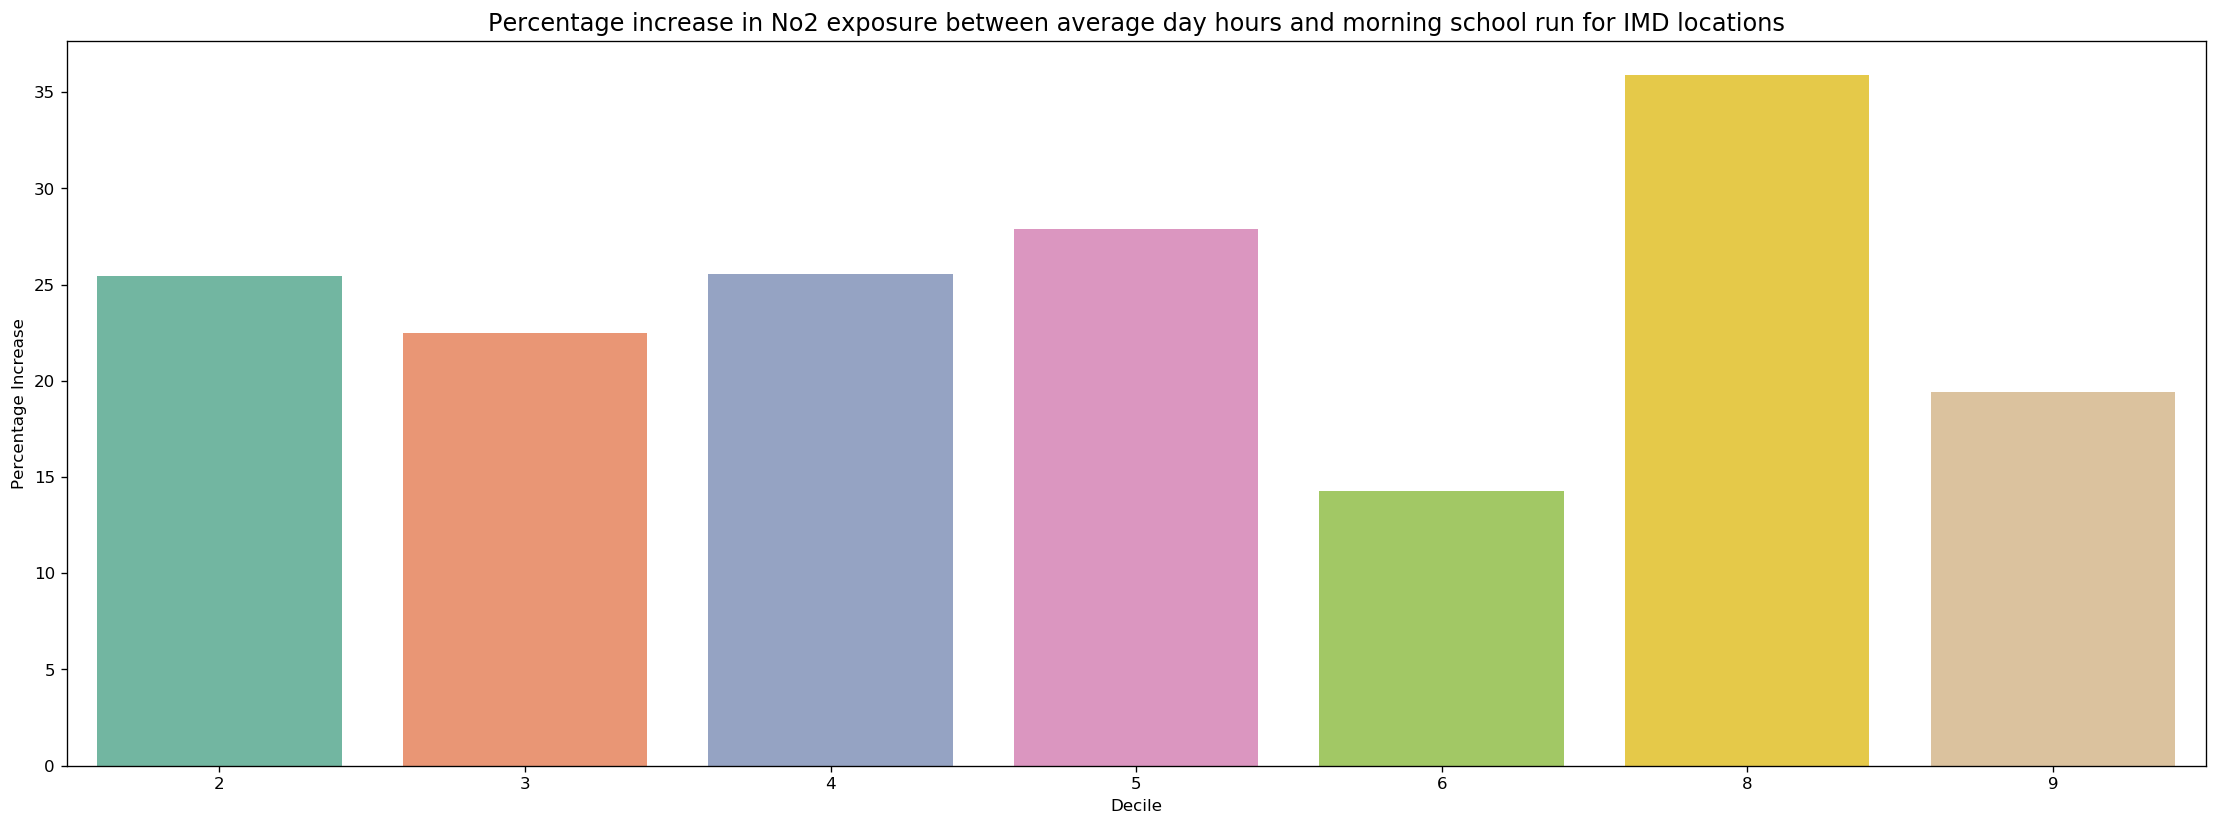

In [60]:
ax = sns.barplot(x='Decile', y='percentage increase', data = df_imd, palette='Set2')
ax.set_title("Percentage increase in No2 exposure between average day hours and morning school run for IMD locations", size = 'x-large')
ax.set(xlabel='Decile', ylabel='Percentage Increase')
plt.show()

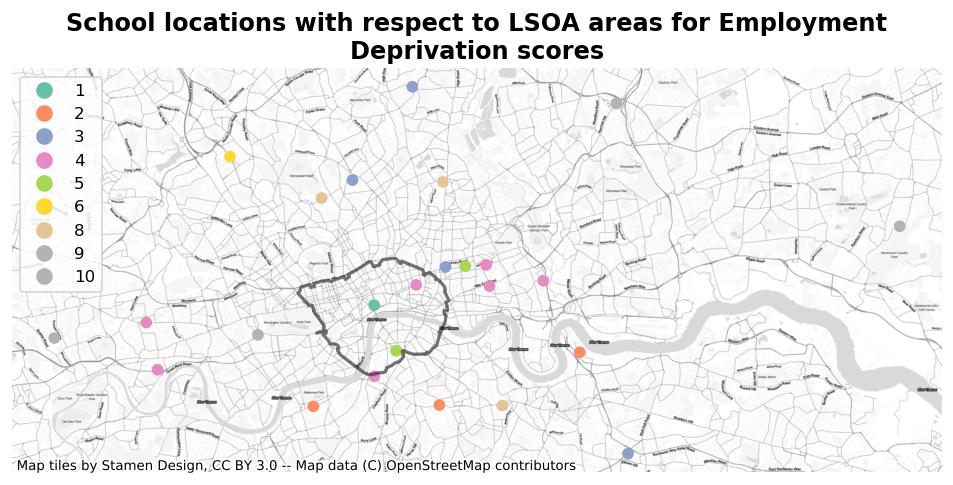

In [61]:
make_lsoa_map('Employment Decile (where 1 is most deprived 10% of LSOAs)',
             'School locations with respect to LSOA areas for Employment\nDeprivation scores')

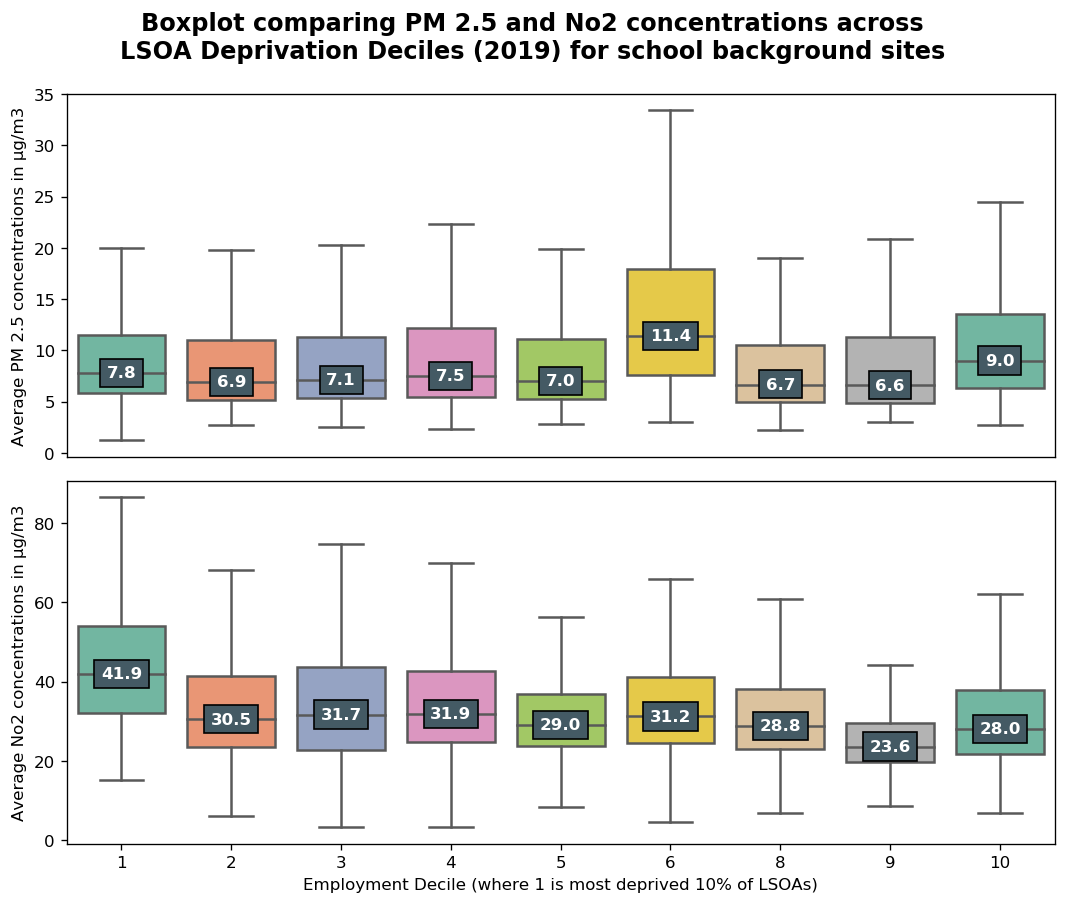

In [62]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across\nLSOA Deprivation Deciles (2019) for school background sites', 
         'Employment Decile (where 1 is most deprived 10% of LSOAs)',
        ['1','2','3','4','5','6','8','9', '10'], 
         df_lsoa)

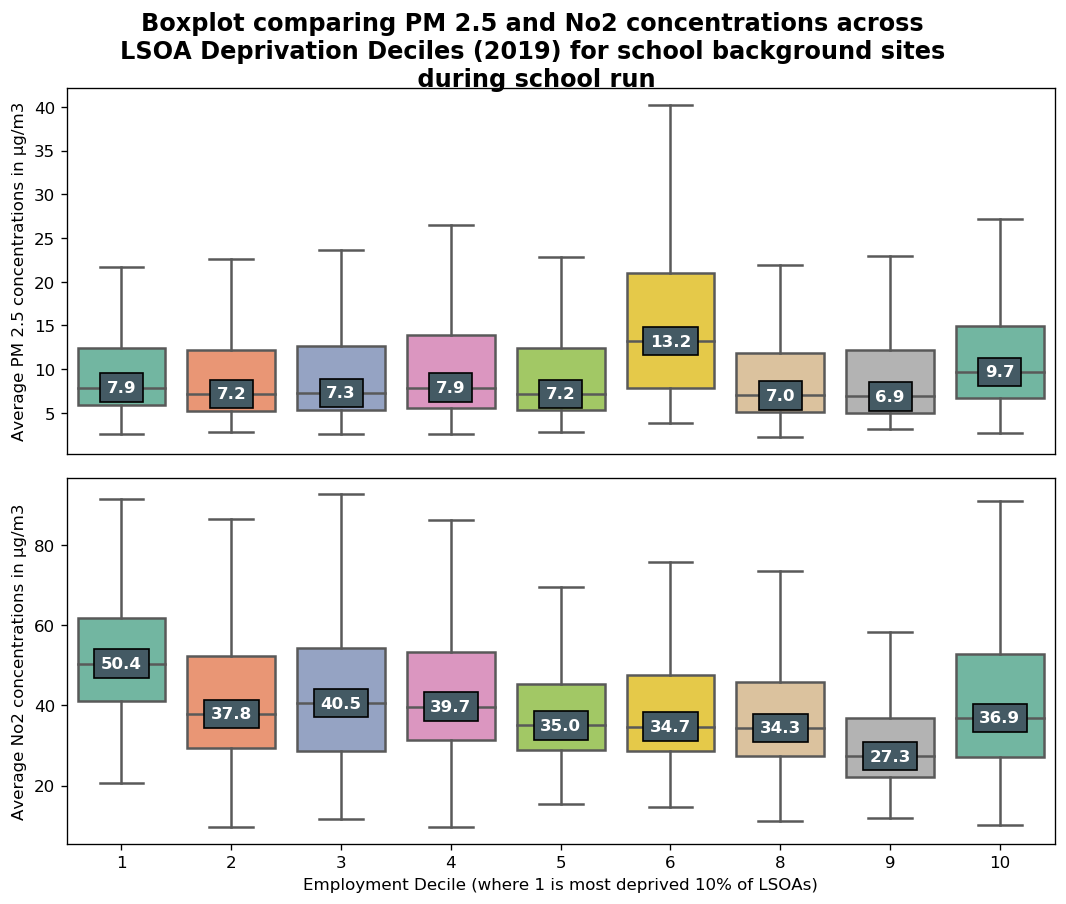

In [63]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across\nLSOA Deprivation Deciles (2019) for school background sites\n during school run', 
         'Employment Decile (where 1 is most deprived 10% of LSOAs)',
        ['1','2','3','4','5','6','8','9', '10'], 
         df_lsoa[df_lsoa['morning school run'] == 'school run'])

### Again the schools in the most deprived employment decile have the highest exposure to NO2, however this school does seem to be in an affluent part of London...

In [64]:
df_employ = pd.DataFrame({
'Decile': [1,2,3,4,5,6,8,9,10],
'Day Median': [41.9, 30.5, 31.7, 31.9, 29, 31.2, 28.8, 23.6, 28],
'School Run Median': [50.4, 37.8, 40.5, 39.7, 35, 34.7, 34.3, 27.3, 36.9]})

In [65]:
x = df_employ['Day Median']
y = df_employ['School Run Median']

df_employ['percentage increase'] = ((y-x)/x)*100

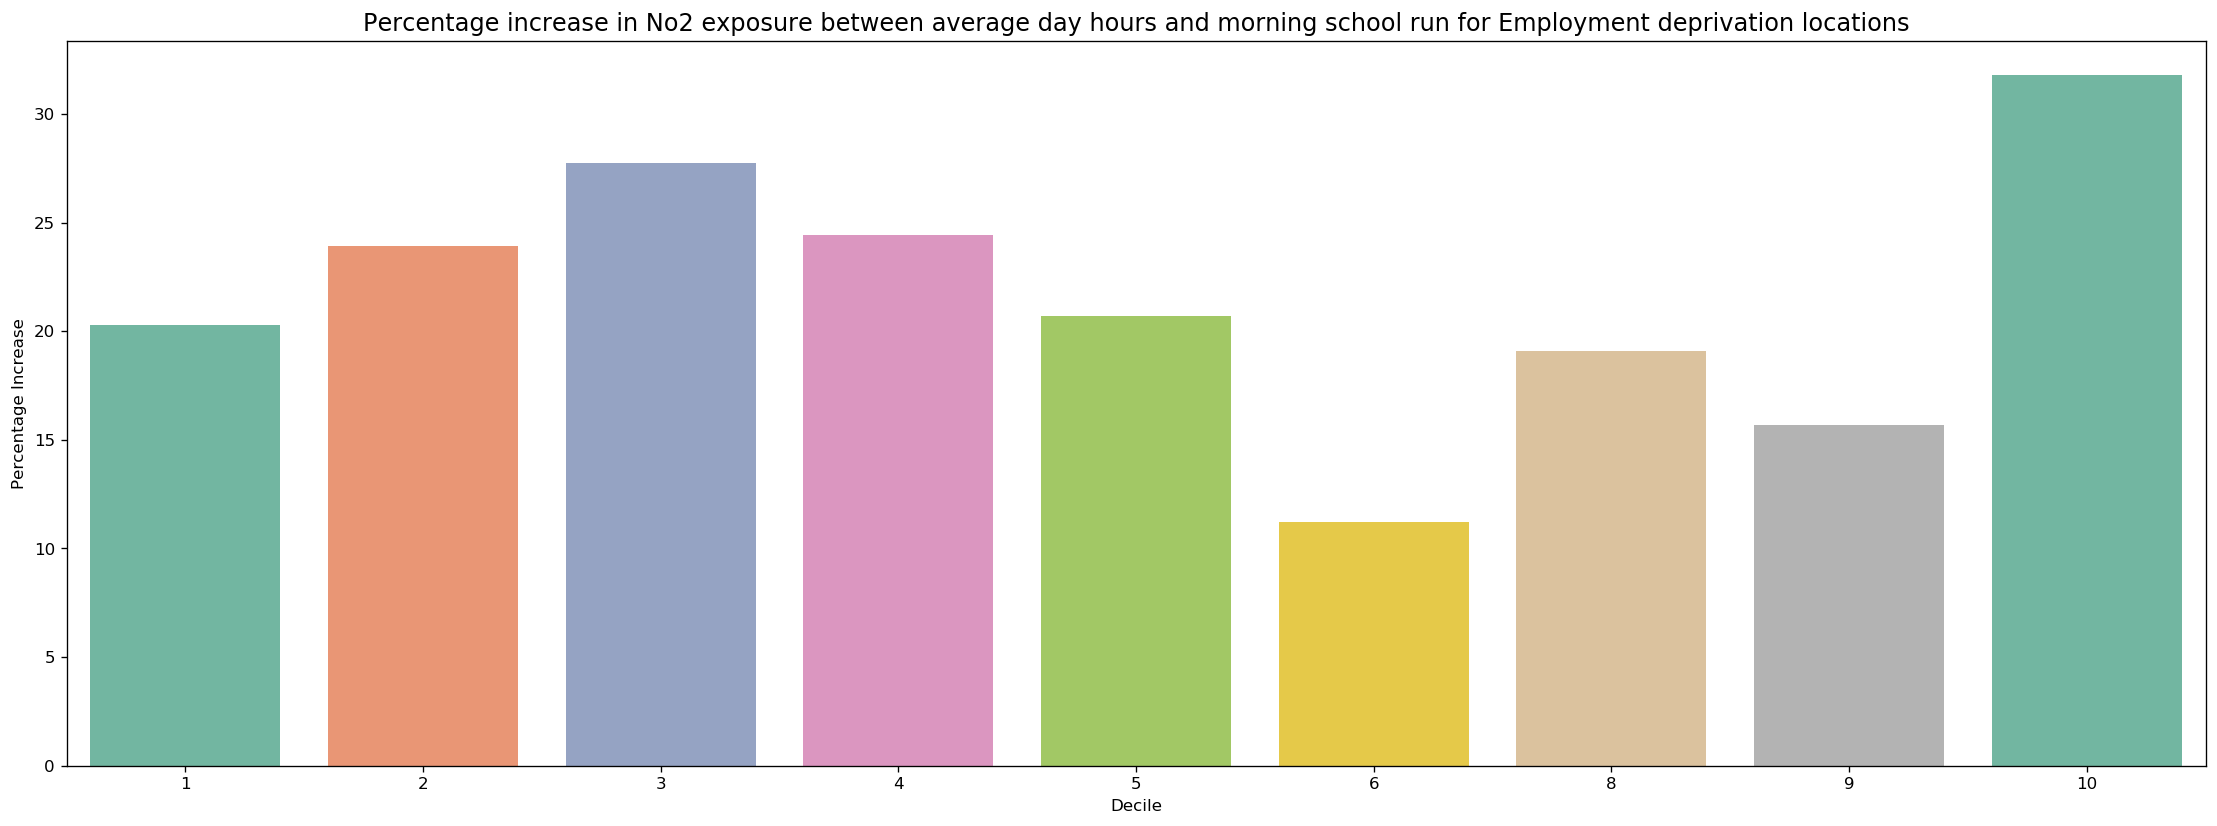

In [66]:
ax = sns.barplot(x='Decile', y='percentage increase', data = df_employ, palette='Set2') 
ax.set_title("Percentage increase in No2 exposure between average day hours and morning school run for Employment deprivation locations", size = 'x-large')
ax.set(xlabel='Decile', ylabel='Percentage Increase')
plt.show()

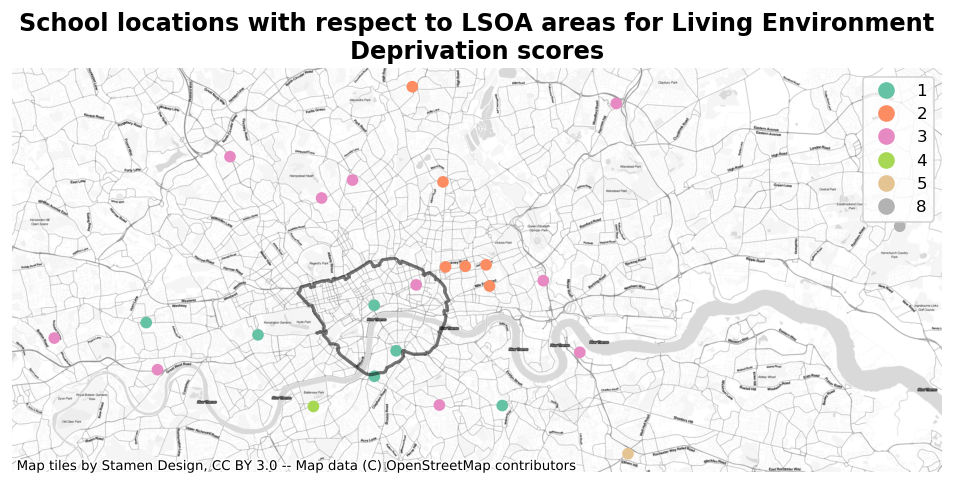

In [67]:
make_lsoa_map('Living Environment Decile (where 1 is most deprived 10% of LSOAs)',
             'School locations with respect to LSOA areas for Living Environment\nDeprivation scores')

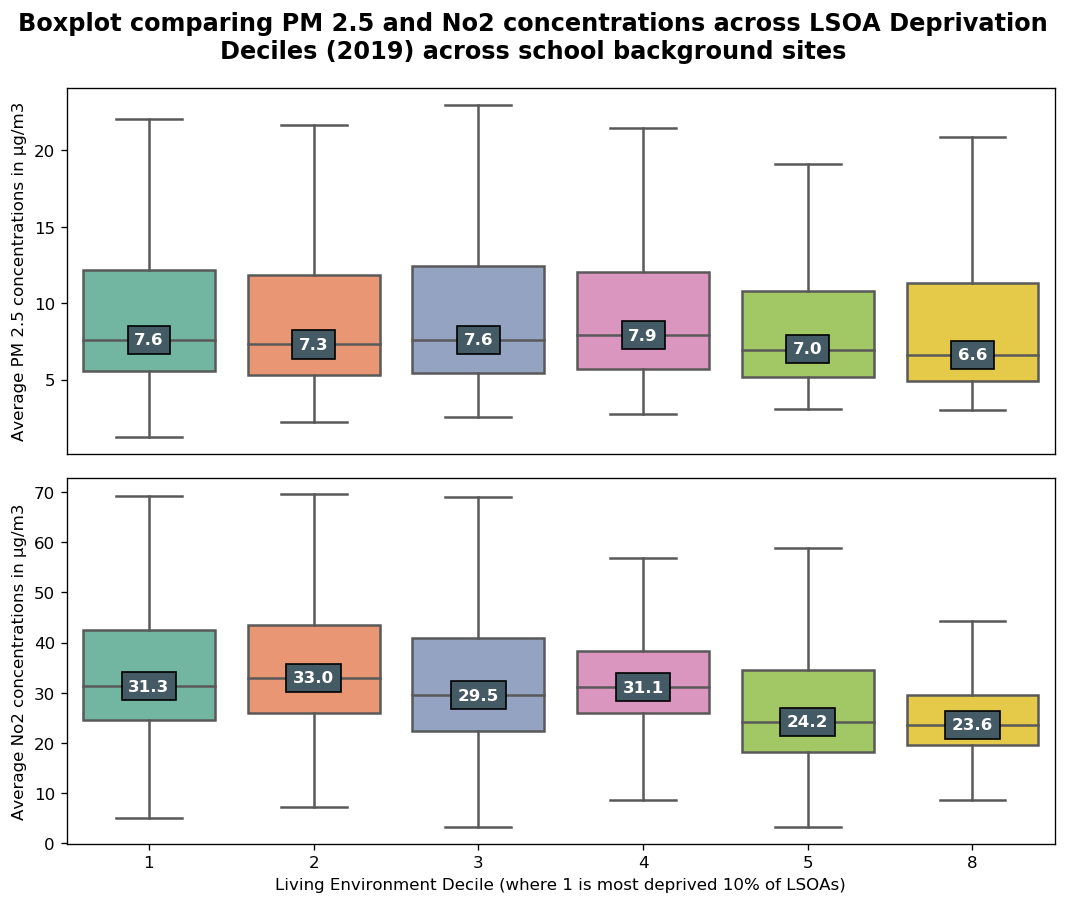

In [68]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across LSOA Deprivation\nDeciles (2019) across school background sites', 
         'Living Environment Decile (where 1 is most deprived 10% of LSOAs)',
        None, df_lsoa)

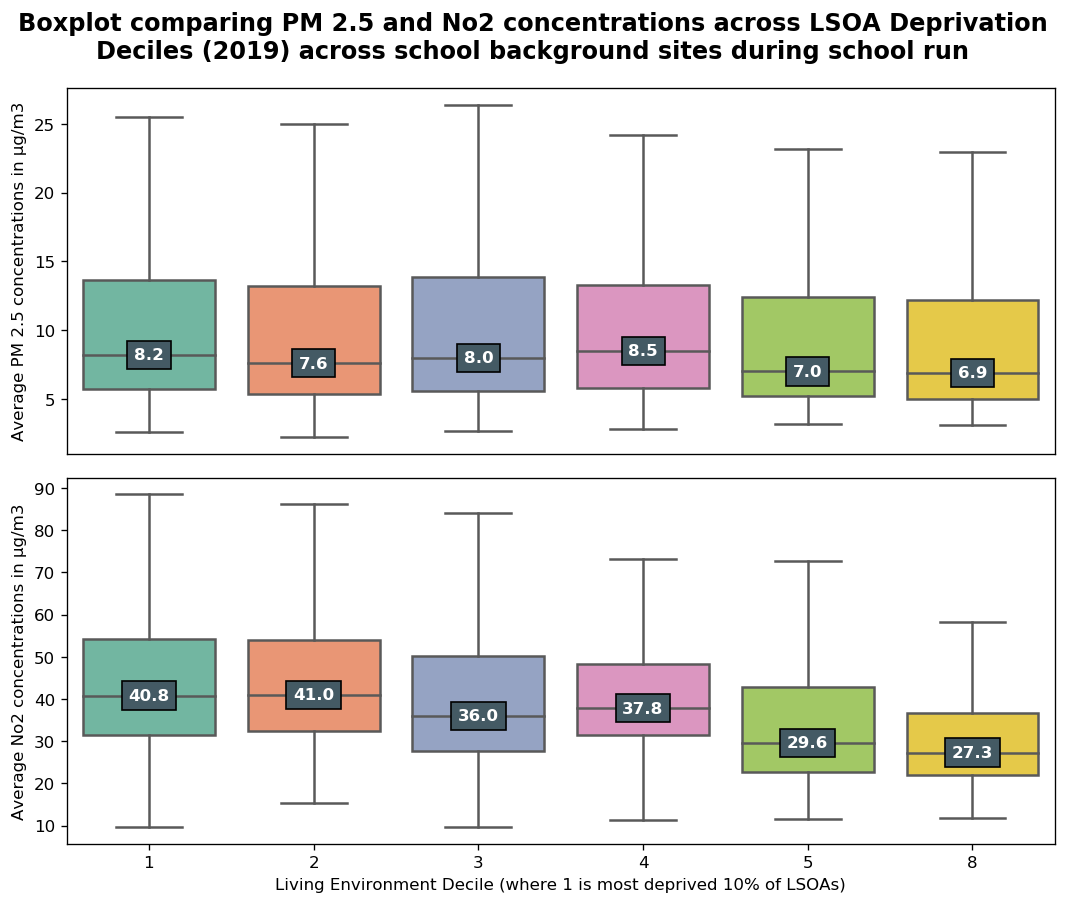

In [69]:
box_lsoa('Boxplot comparing PM 2.5 and No2 concentrations across LSOA Deprivation\nDeciles (2019) across school background sites during school run', 
         'Living Environment Decile (where 1 is most deprived 10% of LSOAs)',
        None, df_lsoa[df_lsoa['morning school run'] == 'school run'])

In [70]:
df_living = pd.DataFrame({
'Decile': [1,2,3,4,5,8],
'Day Median': [31.3, 33, 29.5, 31.1, 24.2, 23.6],
'School Run Median': [40.8, 41, 36, 37.8, 29.6, 27.3]})

In [71]:
x = df_living['Day Median']
y = df_living['School Run Median']

df_living['percentage increase'] = ((y-x)/x)*100

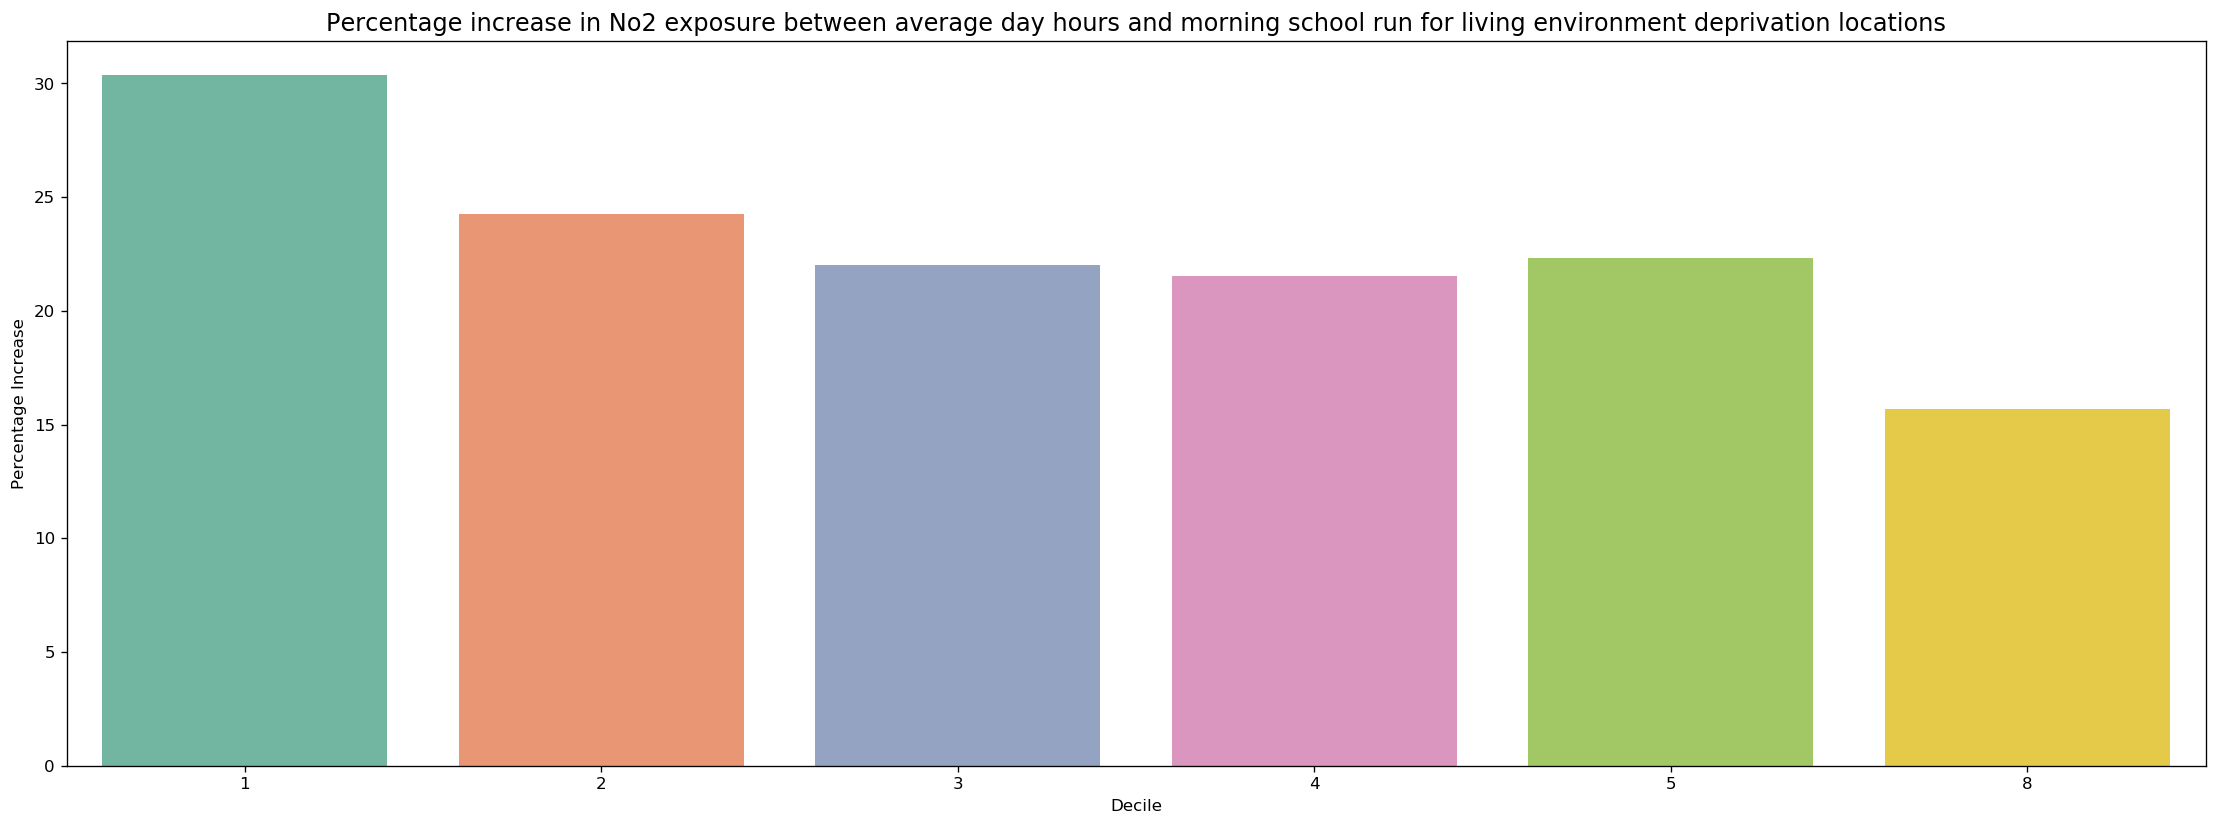

In [72]:
ax = sns.barplot(x='Decile', y='percentage increase', data = df_living, palette='Set2') 
ax.set_title("Percentage increase in No2 exposure between average day hours and morning school run for living environment deprivation locations", size = 'x-large')
ax.set(xlabel='Decile', ylabel='Percentage Increase') 
plt.show()

Adding categories for pollution ranges 

In [73]:
def get_value_no2(range):
    if range < 10:
        return 'Below 10'
    elif range < 20:
        return 'Between 10 and 20'
    elif range < 30:
        return 'Between 20 and 30'
    elif range < 40:
        return 'Between 30 and 40'
    elif range >= 40:
        return 'Above 40'
    else:
        return np.nan

In [74]:
def get_value_pm(range):
    if range < 3:
        return 'Below 3'
    elif range < 6:
        return 'Between 3 and 6'
    elif range < 9:
        return 'Between 6 and 9'
    elif range < 12:
        return 'Between 9 and 12'
    elif range >= 12:
        return 'Above 12'
    else:
        return np.nan
    
#very bad coding... don't do this if dataframe is large!

In [75]:
df_school['range_no2'] = df_school.apply(lambda x: get_value_no2(x['no2_ugm3']), axis=1)
df_school['range_pm25'] = df_school.apply(lambda x: get_value_pm(x['pm2_5_ugm3']), axis=1)

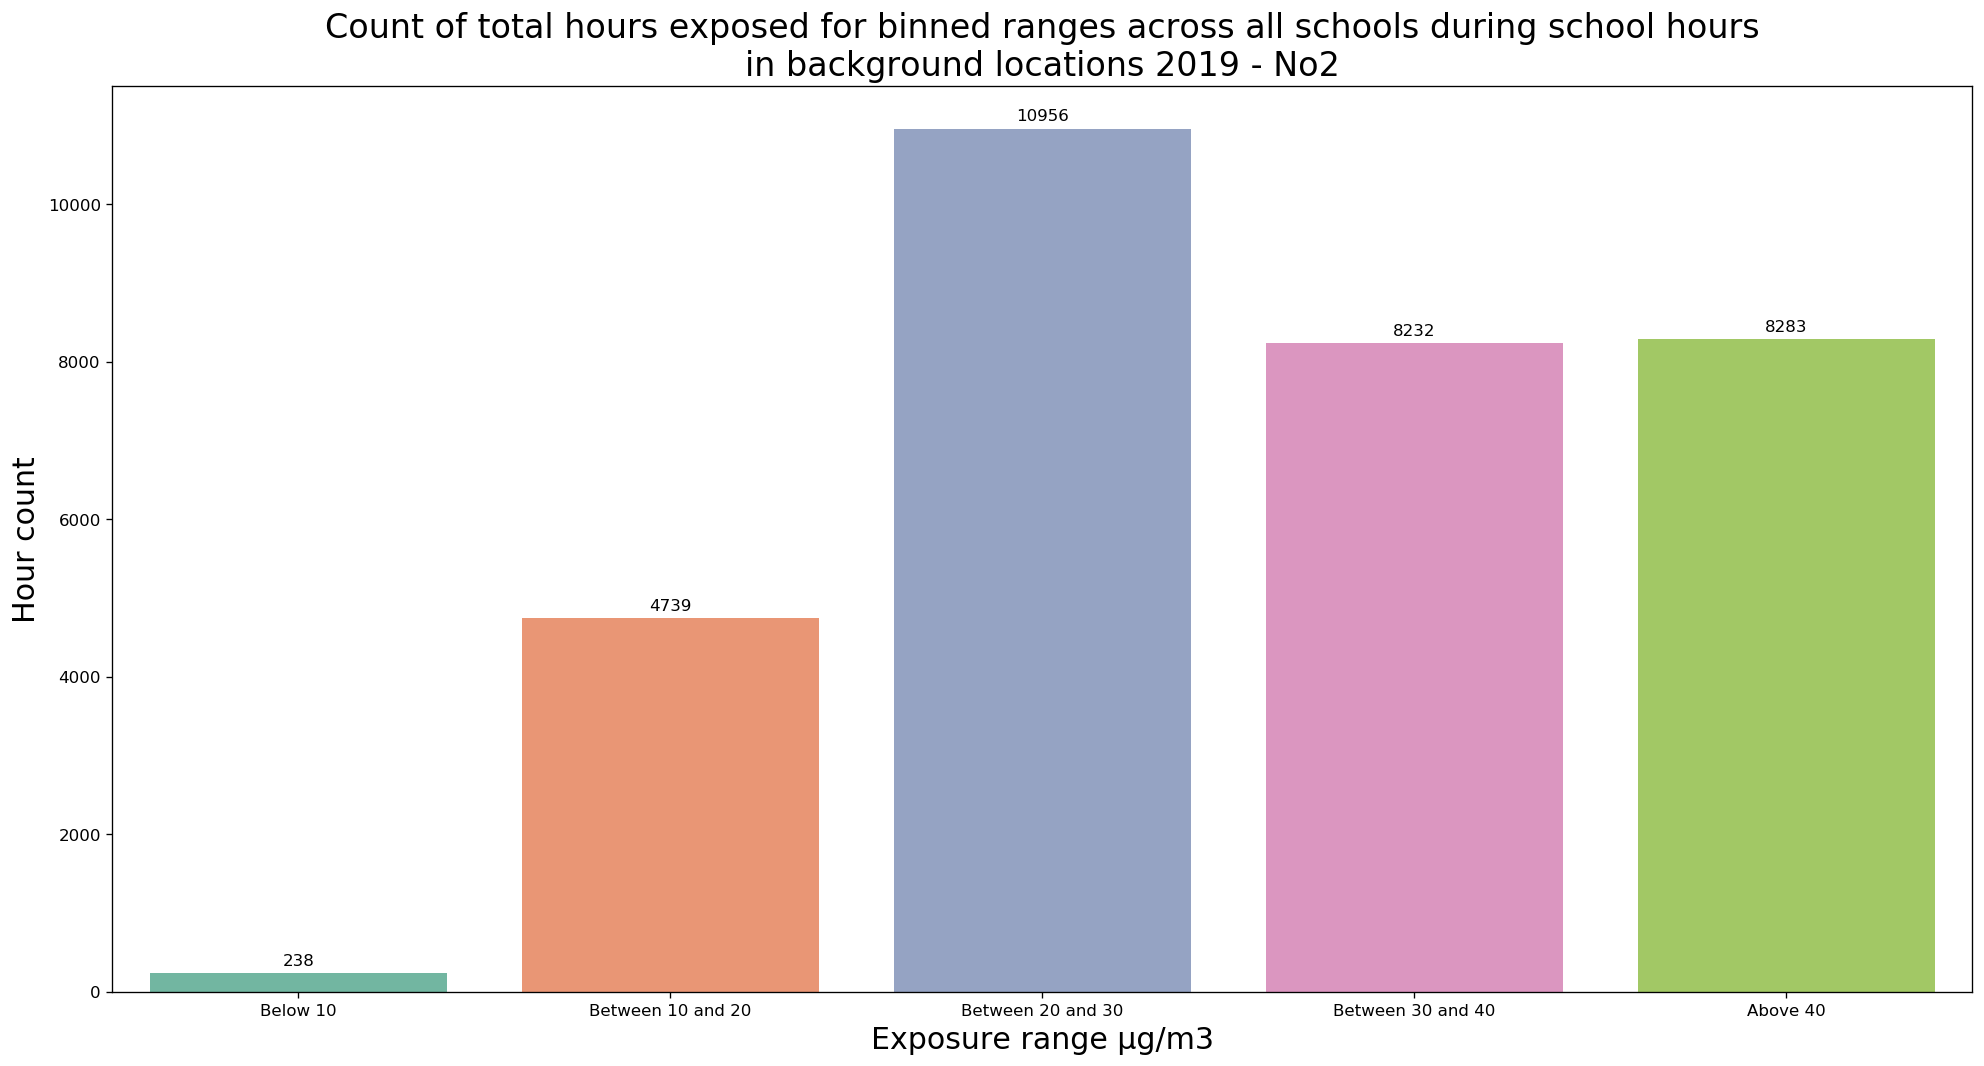

In [76]:
order = ['Below 10', 'Between 10 and 20', 'Between 20 and 30', 'Between 30 and 40', 'Above 40']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(ax=ax,x='range_no2', data=df_school, order=order, palette = 'Set2')

plt.xlabel('Exposure range µg/m3', fontsize=18)
plt.ylabel('Hour count', fontsize=18)
plt.title('Count of total hours exposed for binned ranges across all schools during school hours\nin background locations 2019 - No2',
         fontsize = 20)

for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2., height + 100,height ,ha="center")

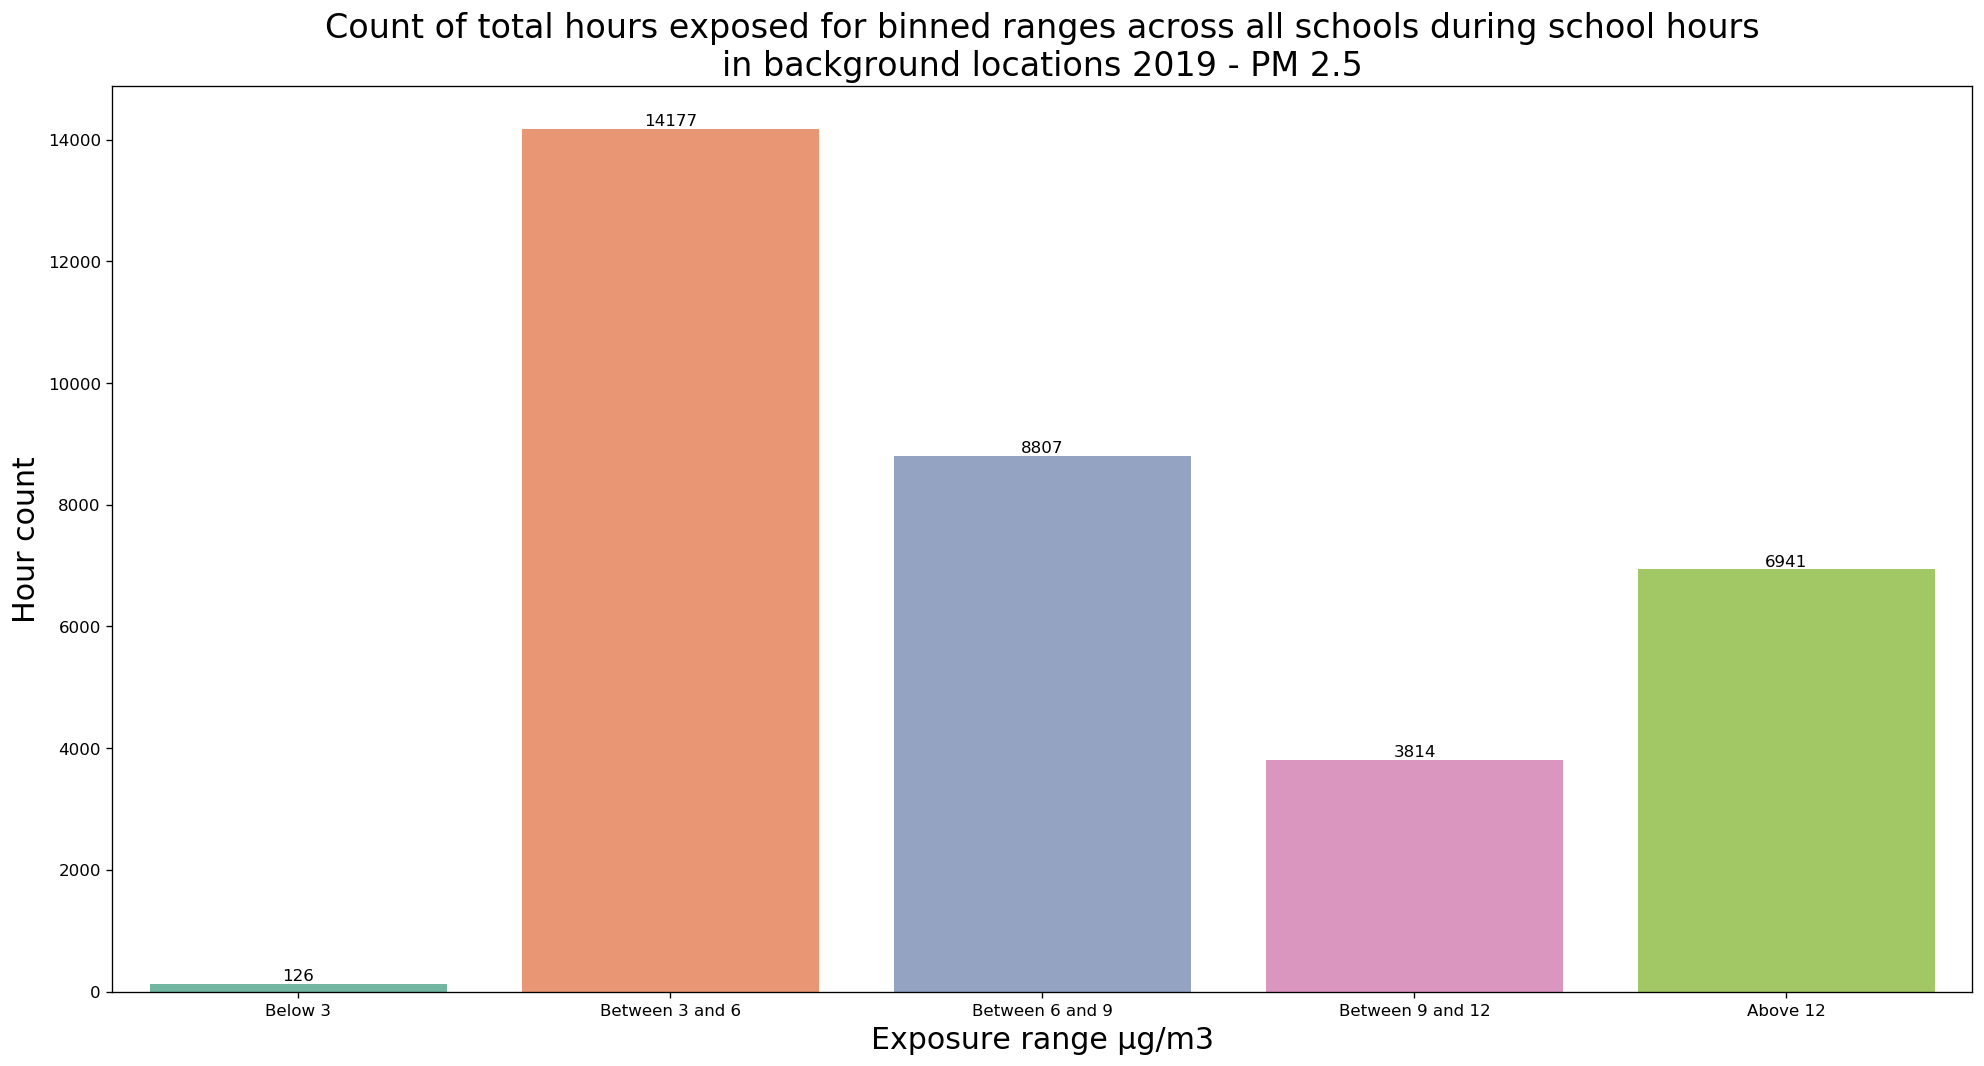

In [77]:
order = ['Below 3', 'Between 3 and 6', 'Between 6 and 9', 'Between 9 and 12', 'Above 12']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(ax=ax,x='range_pm25', data=df_school, order=order, palette = 'Set2')

plt.xlabel('Exposure range µg/m3', fontsize=18)
plt.ylabel('Hour count', fontsize=18)
plt.title('Count of total hours exposed for binned ranges across all schools during school hours\nin background locations 2019 - PM 2.5',
         fontsize = 20)

for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2., height + 50,height ,ha="center")

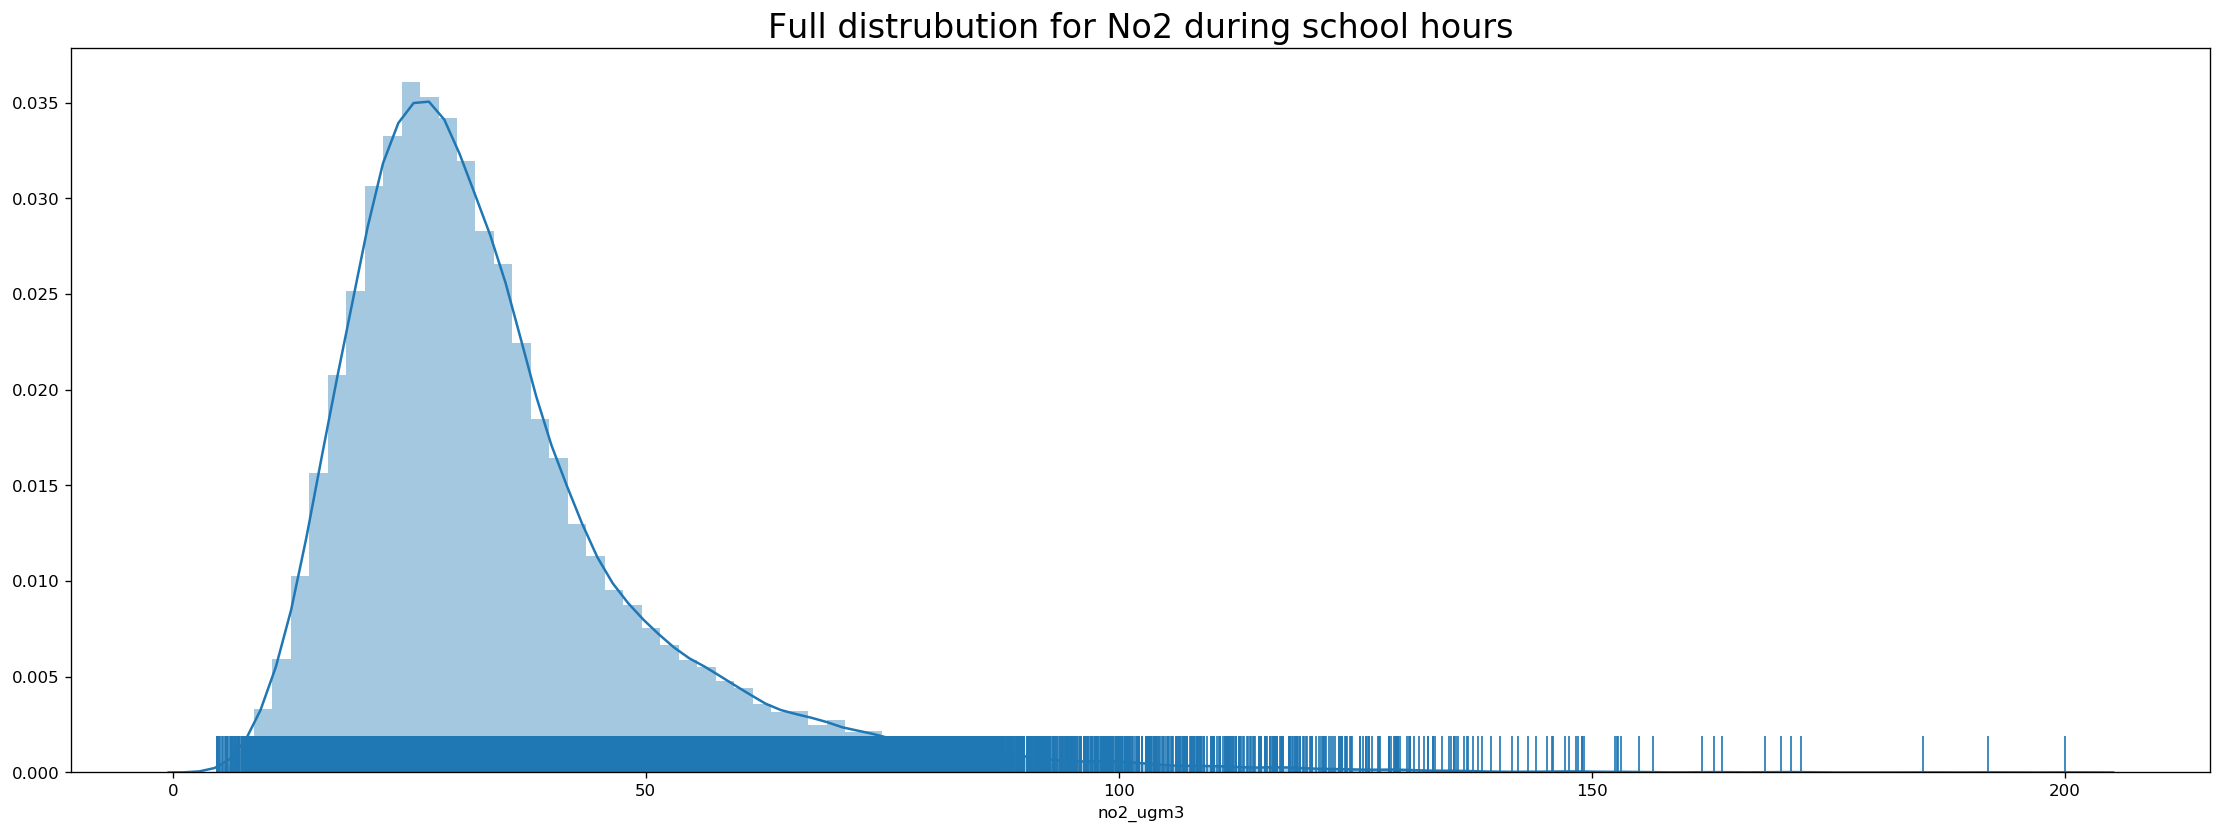

In [78]:
sns.distplot(df_school['no2_ugm3'].dropna(), bins=100, rug=True)
plt.title('Full distrubution for No2 during school hours', size = 20)
plt.show()

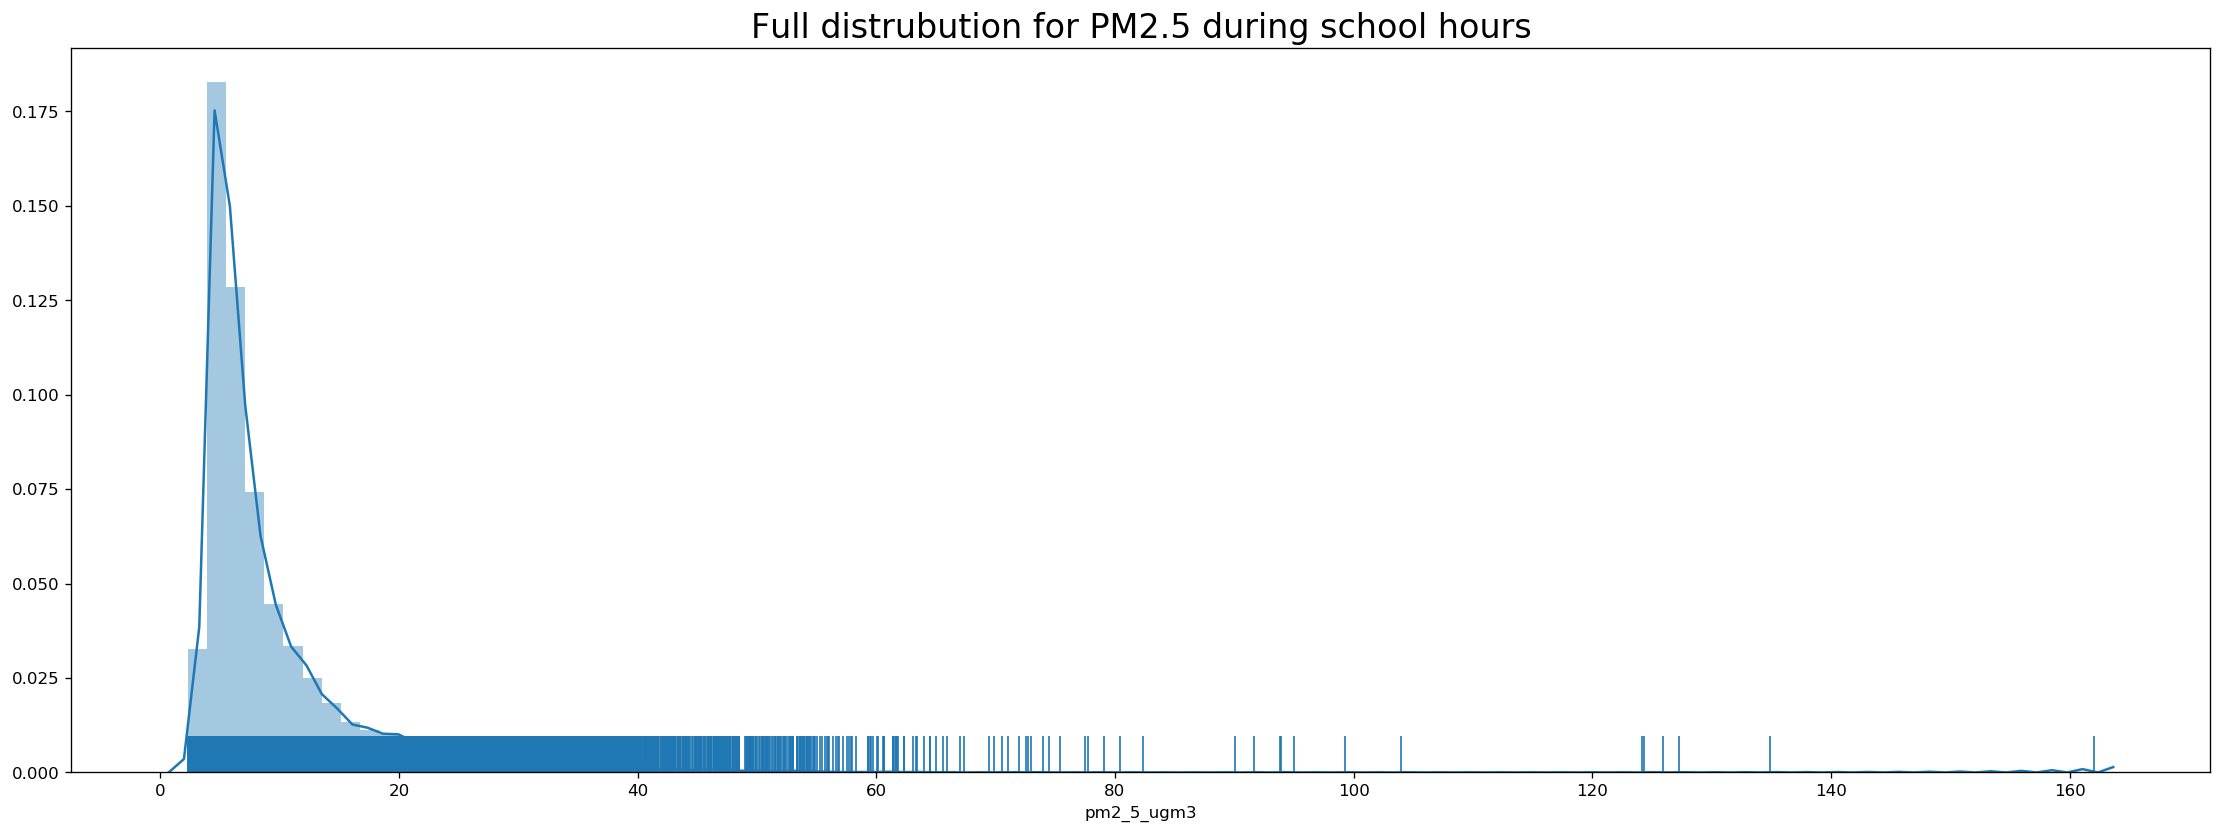

In [79]:
sns.distplot(df_school['pm2_5_ugm3'].dropna(), bins=100, rug=True)
plt.title('Full distrubution for PM2.5 during school hours', size = 20)
plt.show()